In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EDA").getOrCreate()

tripdata_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group_8/tripdata_cleaned", header=True, inferSchema=True)



tripdata_df.printSchema()


root
 |-- hvfhs_license_num: string (nullable = true)
 |-- request_datetime: timestamp (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = 

In [2]:
from pyspark.sql import functions as F

# Assuming tripdata_df is your PySpark DataFrame
tripdata_df = tripdata_df.filter(
    ~(
        (F.col("DOLocationID") == "265") |
        (F.col("DOLocationID") == "264") |
        (F.col("PULocationID") == "265") |
        (F.col("PULocationID") == "264")
    )
)


In [3]:
from pyspark.sql.functions import when, col

# Mapping of codes to company names
code_to_company = {
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft"
}

# Initialize the column expression with a default value (here we use the existing column value)
column_expr = col("hvfhs_license_num")

# Chain when clauses for each mapping
for code, company in code_to_company.items():
    column_expr = when(col("hvfhs_license_num") == code, company).otherwise(column_expr)

# Apply the transformation to create the new "company" column
tripdata_df = tripdata_df.withColumn("company", column_expr)

# Show some rows to verify the change
tripdata_df.show()
tripdata_df.printSchema()

23/11/26 20:39:43 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+-------------------+-----------------+------------------+----------------+---------+-------------------+------------+-------------------+-------------+------------------+-----------+------------------+------------+-------+
|hvfhs_license_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wait_time|request_time_of_day|request_hour|request_day_of_week|request_month|pickup_time_of_day|pickup_hour|pickup_day_of_week|pickup_month|company|
+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+

In [5]:
from pyspark.sql import functions as F

# Function to create vertices and edges DataFrames for a given time of day and company
def create_graphs_for_time_and_company(time_of_day, company, tripdata_df):
    filtered_df = tripdata_df.filter(
        (F.col("pickup_time_of_day") == time_of_day) & 
        (F.col("company") == company)
    )
    
    #sample_df = filtered_df.sample(fraction=0.001)-What's better??
    sample_df = filtered_df.sample(withReplacement=False, fraction=25000 / filtered_df.count())

    print(sample_df.count())

    vertices_df = (sample_df.select(F.col("PULocationID").alias("LocationID"))
                   .union(sample_df.select(F.col("DOLocationID").alias("LocationID")))
                   .distinct())

    edges_df = sample_df.select("PULocationID", "DOLocationID", 
                                  F.lit("travels to").alias("type"))

    return vertices_df, edges_df

# Creating DataFrames for each time of day and company
morning_uber_vertices_df, morning_uber_edges_df = create_graphs_for_time_and_company("morning", "Uber", tripdata_df)
afternoon_uber_vertices_df, afternoon_uber_edges_df = create_graphs_for_time_and_company("afternoon", "Uber", tripdata_df)
evening_uber_vertices_df, evening_uber_edges_df = create_graphs_for_time_and_company("evening", "Uber", tripdata_df)
night_uber_vertices_df, night_uber_edges_df = create_graphs_for_time_and_company("night", "Uber", tripdata_df)

morning_lyft_vertices_df, morning_lyft_edges_df = create_graphs_for_time_and_company("morning", "Lyft", tripdata_df)
afternoon_lyft_vertices_df, afternoon_lyft_edges_df = create_graphs_for_time_and_company("afternoon", "Lyft", tripdata_df)
evening_lyft_vertices_df, evening_lyft_edges_df = create_graphs_for_time_and_company("evening", "Lyft", tripdata_df)
night_lyft_vertices_df, night_lyft_edges_df = create_graphs_for_time_and_company("night", "Lyft", tripdata_df)

24825


25132


25224


24949


24996


25164


25182


24927


In [6]:
# Renaming columns for all vertices DataFrames
morning_uber_vertices_df = morning_uber_vertices_df.withColumnRenamed("LocationID", "id")
afternoon_uber_vertices_df = afternoon_uber_vertices_df.withColumnRenamed("LocationID", "id")
evening_uber_vertices_df = evening_uber_vertices_df.withColumnRenamed("LocationID", "id")
night_uber_vertices_df = night_uber_vertices_df.withColumnRenamed("LocationID", "id")

morning_lyft_vertices_df = morning_lyft_vertices_df.withColumnRenamed("LocationID", "id")
afternoon_lyft_vertices_df = afternoon_lyft_vertices_df.withColumnRenamed("LocationID", "id")
evening_lyft_vertices_df = evening_lyft_vertices_df.withColumnRenamed("LocationID", "id")
night_lyft_vertices_df = night_lyft_vertices_df.withColumnRenamed("LocationID", "id")

# Renaming columns for all edges DataFrames
morning_uber_edges_df = morning_uber_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
afternoon_uber_edges_df = afternoon_uber_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
evening_uber_edges_df = evening_uber_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
night_uber_edges_df = night_uber_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")

morning_lyft_edges_df = morning_lyft_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
afternoon_lyft_edges_df = afternoon_lyft_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
evening_lyft_edges_df = evening_lyft_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
night_lyft_edges_df = night_lyft_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")


In [7]:
from graphframes import *

morning_uber_graph = GraphFrame(morning_uber_vertices_df, morning_uber_edges_df)
afternoon_uber_graph = GraphFrame(afternoon_uber_vertices_df, afternoon_uber_edges_df)
evening_uber_graph = GraphFrame(evening_uber_vertices_df, evening_uber_edges_df)
night_uber_graph = GraphFrame(night_uber_vertices_df, night_uber_edges_df)


morning_lyft_graph = GraphFrame(morning_lyft_vertices_df, morning_lyft_edges_df)
afternoon_lyft_graph = GraphFrame(afternoon_lyft_vertices_df, afternoon_lyft_edges_df)
evening_lyft_graph = GraphFrame(evening_lyft_vertices_df, evening_lyft_edges_df)
night_lyft_graph = GraphFrame(night_lyft_vertices_df, night_lyft_edges_df)

In [8]:


morning_uber_pr = morning_uber_graph.pageRank(resetProbability=0.15, maxIter = 5)
afternoon_uber_pr = afternoon_uber_graph.pageRank(resetProbability=0.15, maxIter = 5)
evening_uber_pr = evening_uber_graph.pageRank(resetProbability=0.15, maxIter = 5)
night_uber_pr = night_uber_graph.pageRank(resetProbability=0.15, maxIter = 5)


morning_lyft_pr = morning_lyft_graph.pageRank(resetProbability=0.15, maxIter = 5)
afternoon_lyft_pr = afternoon_lyft_graph.pageRank(resetProbability=0.15, maxIter = 5)
evening_lyft_pr = evening_lyft_graph.pageRank(resetProbability=0.15, maxIter = 5)
night_lyft_pr = night_lyft_graph.pageRank(resetProbability=0.15, maxIter = 5)



In [9]:

morning_uber_pr.vertices.orderBy('pagerank',ascending=False).show()
afternoon_uber_pr.vertices.orderBy('pagerank',ascending=False).show()
evening_uber_pr.vertices.orderBy('pagerank',ascending=False).show()
night_uber_pr.vertices.orderBy('pagerank',ascending=False).show()




morning_lyft_pr.vertices.orderBy('pagerank',ascending=False).show()
afternoon_lyft_pr.vertices.orderBy('pagerank',ascending=False).show()
evening_lyft_pr.vertices.orderBy('pagerank',ascending=False).show()
night_lyft_pr.vertices.orderBy('pagerank',ascending=False).show()

+---+------------------+
| id|          pagerank|
+---+------------------+
|138| 6.865004699111953|
|132| 6.493218615675582|
|161| 5.344829684436382|
|162| 3.419267224733126|
|246| 3.080519546414268|
|231|  2.92662386390276|
|230|2.9150870402566254|
|  1| 2.762807558706969|
|234|2.7472291557705364|
|186| 2.626579823272071|
|237|2.6029461425948592|
|170| 2.602828862045409|
|163| 2.577858020027172|
| 23| 2.487696668266654|
|244| 2.357628575767509|
|236| 2.305822679784324|
| 68|2.2842604218714637|
|130| 2.212315840398876|
|140| 2.201959623646728|
|164|2.0868154758238124|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
|132| 4.550236858311124|
|138|3.9926558867116317|
| 61|2.9085317875591437|
| 76|2.6868414054822196|
|161|2.5011413718919164|
|130| 2.235711711739041|
|186| 2.197146771510325|
|237|2.1602259516654794|
|231|2.1576395498140686|
|234|2.1475749780493616|
|230| 2.120698905123651|
| 95| 2.072309671844265|
|181| 2.062327286444242|
|236|2.0462087512319056|
| 79| 2.035214277528522|
|170|2.0254868003940114|
|  7|1.9864433397022638|
|255|1.9639707912008408|
| 37|1.9603689468710563|
|246|1.9168740529645762|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
| 61| 3.110664758004518|
| 79| 2.929930595605622|
| 76|2.8403207567031346|
| 37| 2.563521643533623|
|  7| 2.508988248131141|
|255| 2.464876840582595|
|132|2.4136739511362224|
|256|2.1779292473261904|
| 17| 2.171648003115317|
|148| 2.109336543443597|
|234|  2.02427623509468|
|230|1.9920506501904118|
|181|1.9506009880584718|
|225|1.9373950463274283|
| 82|1.9242336099558512|
|244| 1.919034667106546|
| 89|1.9116747802629077|
| 42|1.8994558346873778|
|129|1.8986405748864144|
| 39|1.8876757353495146|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
| 61| 4.529032726756783|
| 37|3.4486691638993405|
| 76|  3.42232525173437|
| 39|2.8988528337048005|
| 89| 2.854215768736714|
| 42|2.7067102759410626|
| 17| 2.540758280104427|
|188|2.4544648318222846|
|132| 2.427340574577502|
|225| 2.408684151787945|
|  7|2.3375419441471688|
|129|2.3260930220965363|
| 36|2.2307783980720663|
| 14|2.2152417897249643|
|169| 2.165545462595358|
|243| 2.075308448557736|
|244|2.0221099749736586|
|235|2.0199740073579204|
| 48|1.9973269260979445|
| 72|1.9915350078514598|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
|138| 7.941550942472946|
|132|   6.3664326768441|
|161|  4.15493354653791|
|246| 3.044729944002236|
|186|2.9630364550952506|
|162| 2.916988500660324|
|170|2.7503709025380267|
|  1| 2.748025844432373|
|234|2.6240686481890485|
|230|2.5783299004202695|
|140|2.5469440024445764|
|231| 2.483454545254551|
|181| 2.475544530817912|
| 68|2.3474764310855587|
| 61| 2.316306609600623|
|244|2.2477513592873755|
|130| 2.195164516650893|
|237| 2.107315766906814|
| 13| 2.098804977315063|
| 42|1.9865072610333245|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
|132| 4.820675325592599|
|138| 4.749134316542686|
| 61| 3.111580129498182|
|181| 2.642773513939806|
| 76| 2.541410734217402|
| 37| 2.325890750054532|
| 79| 2.324813095839812|
|  7| 2.307043134758945|
|255| 2.289151600159371|
| 89| 2.285284298973341|
| 42|2.2633739601806555|
|130|2.1446779002940075|
| 17|2.0644028979256737|
|  1|2.0343676437368234|
| 68|1.9736473189904973|
| 74|     1.97169564648|
| 48|1.9570594229427212|
| 95|1.9413944563973218|
|186| 1.941045911468974|
|234|1.9214691834754019|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
| 61| 4.178062492041353|
| 79| 3.344960315123918|
| 76| 3.103320847902292|
| 37|  2.90554201466892|
|181| 2.795124354311817|
|  7|2.7105984661679607|
|255|2.6460541492668117|
|132| 2.482702557535729|
| 17| 2.346691484002098|
| 42|2.3057348733241345|
|188| 2.271098521801753|
|112|2.2498194506653832|
|225|2.2293193875127852|
|148|2.2285821626166196|
|256|  2.21645503170113|
| 80| 2.200023529924356|
| 89| 2.165772577513075|
| 74| 2.147583317433966|
| 48|2.0570122776415363|
| 36|2.0109258943363124|
+---+------------------+
only showing top 20 rows



+---+------------------+
| id|          pagerank|
+---+------------------+
| 61| 5.145098986164507|
| 37| 4.098884843978123|
|225|3.1864624738562037|
| 76|3.0806679064208535|
| 42| 3.069527302990796|
| 17| 3.016848333431225|
| 89|2.9688172419923706|
|  7|2.7493977384089727|
|132|2.7288641676595256|
| 79| 2.725134932327603|
| 36|2.6674197001797193|
|188|2.4874838905826624|
| 80| 2.386159900563992|
|181| 2.260455932068583|
|256|2.1335636698664047|
|112| 2.041949635699197|
|244|2.0063929888444743|
|138|1.9775021179278058|
| 48|1.9721453823975372|
| 74| 1.954024801358068|
+---+------------------+
only showing top 20 rows



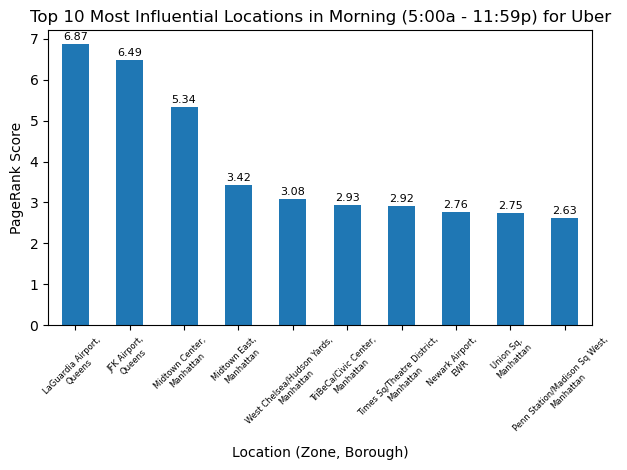

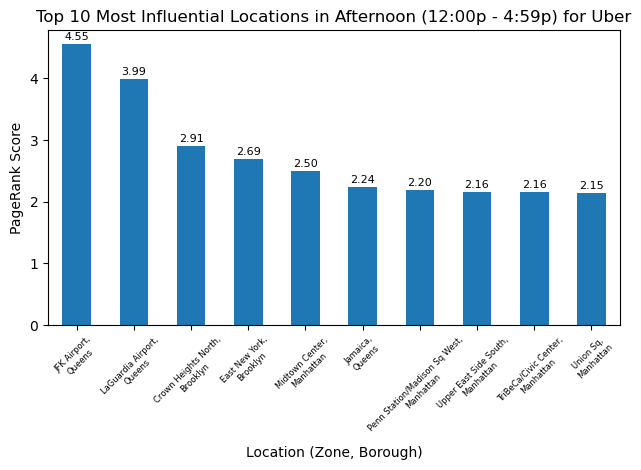

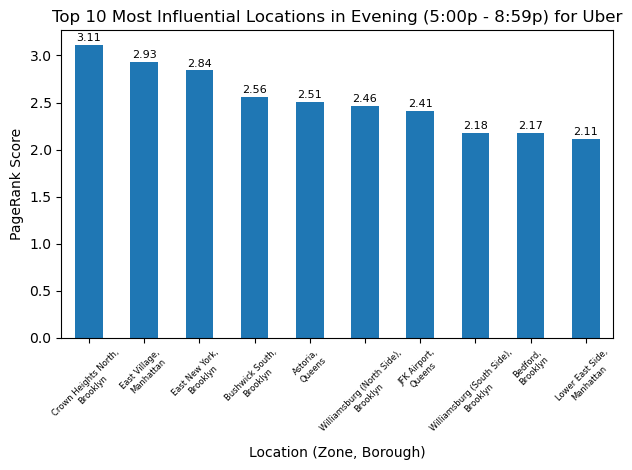

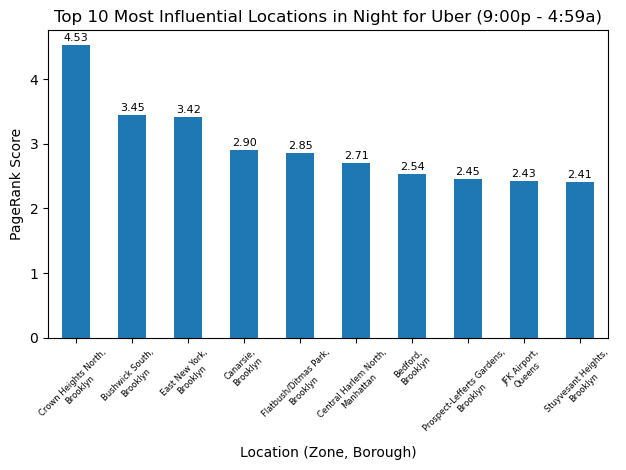

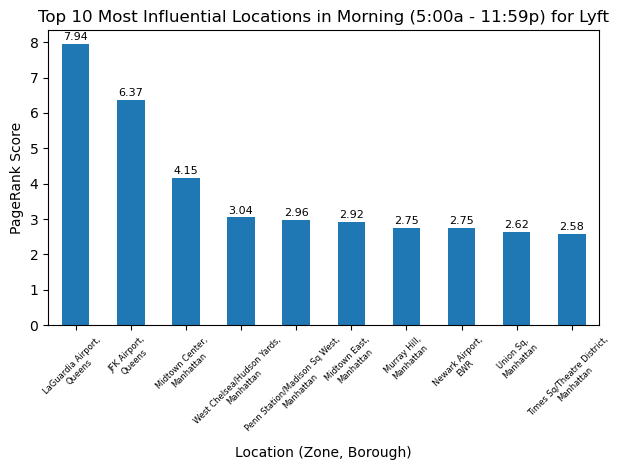

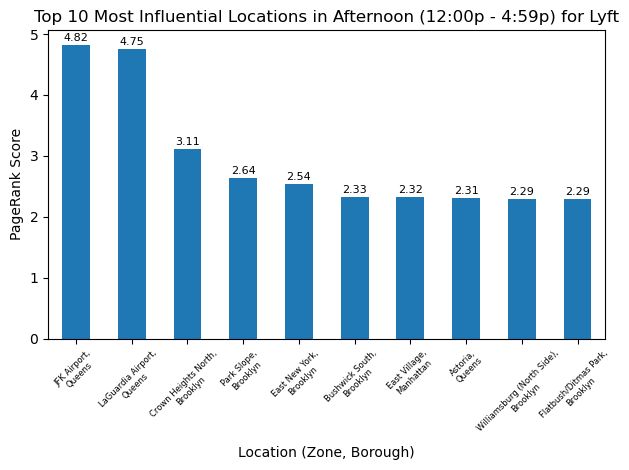

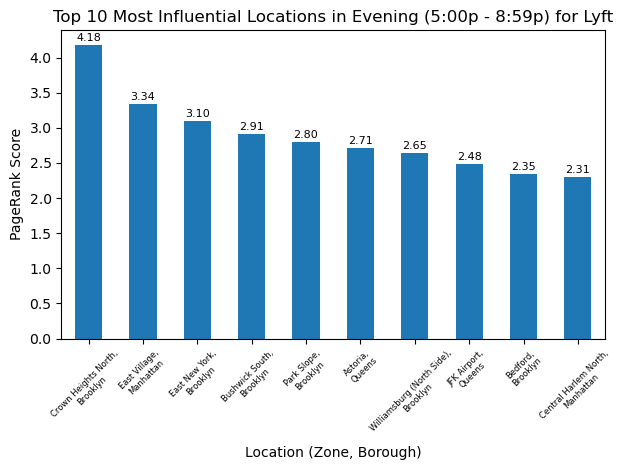

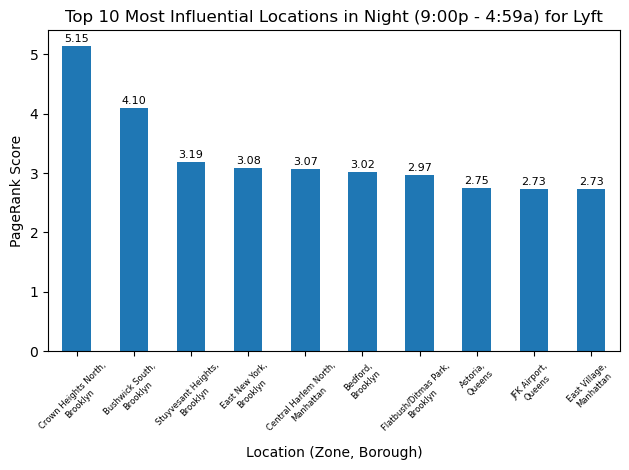

In [10]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws


# Read the CSV file into a DataFrame
location_df = spark.read.csv("gs://msca-bdp-student-gcs/Group_8/taxi+_zone_lookup.csv", header=True, inferSchema=True)

# Define a function to plot the bar charts
def plot_top_locations(df, time_period, service):
    # Join with the location DataFrame
    joined_df = df.join(location_df, df.id == location_df.LocationID)

    # Create a new column for Zone and Borough
    joined_df = joined_df.withColumn("Zone_Borough", concat_ws(",\n", "Zone", "Borough"))

    # Select top 10 locations based on PageRank
    top_locations = joined_df.orderBy('pagerank', ascending=False).select('Zone_Borough', 'pagerank').limit(10)

    # Convert to Pandas DataFrame for plotting
    pandas_df = top_locations.toPandas()

    # Create bar plot
    ax = pandas_df.plot(kind='bar', x='Zone_Borough', y='pagerank', legend=False, title=f'Top 10 Most Influential Locations in {time_period} for {service}')
    plt.xlabel('Location (Zone, Borough)')
    plt.ylabel('PageRank Score')
    ax.set_xticklabels(pandas_df['Zone_Borough'], rotation=45, fontsize=6)  # Adjust font size here
    
    
    # Annotate with PageRank scores
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')  # Adjust annotation font size and format here

    
    plt.tight_layout()
    plt.show()



# Create and show plots for each DataFrame
plot_top_locations(morning_uber_pr.vertices, "Morning (5:00a - 11:59p)", "Uber")
plot_top_locations(afternoon_uber_pr.vertices, "Afternoon (12:00p - 4:59p)", "Uber")
plot_top_locations(evening_uber_pr.vertices, "Evening (5:00p - 8:59p)", "Uber")
plot_top_locations(night_uber_pr.vertices, "Night", "Uber (9:00p - 4:59a)")
plot_top_locations(morning_lyft_pr.vertices, "Morning (5:00a - 11:59p)", "Lyft")
plot_top_locations(afternoon_lyft_pr.vertices, "Afternoon (12:00p - 4:59p)", "Lyft")
plot_top_locations(evening_lyft_pr.vertices, "Evening (5:00p - 8:59p)", "Lyft")
plot_top_locations(night_lyft_pr.vertices, "Night (9:00p - 4:59a)", "Lyft")


In [23]:
from sklearn.preprocessing import MinMaxScaler

def normalize_pagerank(graph_frame, exclude_top_n=0):
    # Convert to Pandas DataFrame
    pandas_df = graph_frame.vertices.toPandas()

    # Sort by PageRank in descending order
    sorted_df = pandas_df.sort_values(by='pagerank', ascending=False)

    # Extract top N location IDs
    excluded_ids = sorted_df.head(exclude_top_n)['id'].tolist()

    # Exclude top N locations
    pandas_df = sorted_df.iloc[exclude_top_n:]

    # Normalize PageRank scores
    scaler = MinMaxScaler()
    pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])

    return pandas_df, excluded_ids


In [24]:
import geopandas as gpd
from shapely import wkt

def prepare_data_for_plotting(pr_df, location_geom_df, excluded_ids=[]):
    # Convert 'the_geom' column to geometrical data in location_geom_df
    location_geom_df['geometry'] = location_geom_df['the_geom'].apply(wkt.loads)
    full_gdf = gpd.GeoDataFrame(location_geom_df, geometry='geometry')

    # Ensure the 'id' column in pr_df is of the same type as 'OBJECTID' in location_geom_df
    pr_df['id'] = pr_df['id'].astype(location_geom_df['OBJECTID'].dtype)

    # Join PageRank DataFrame with location geometry DataFrame
    merged_gdf = full_gdf.merge(pr_df, left_on='OBJECTID', right_on='id', how='left')

    # Set the pagerank_normalized to 0 (which will be white in the colormap) for excluded ids
    merged_gdf.loc[merged_gdf['OBJECTID'].isin(excluded_ids), 'pagerank_normalized'] = 0

    return merged_gdf


In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def plot_pagerank_maps(gdf, title):
    
    # Define a custom colormap (red to green)
    cdict = {'red':   ((0.0, 0.0, 0.0),   # Green at 0
                       (1.0, 1.0, 1.0)),  # Red at 1

             'green': ((0.0, 1.0, 1.0),   # Green at 0
                       (1.0, 0.0, 0.0)),  # Red at 1

             'blue':  ((0.0, 0.0, 0.0),   # No blue component
                       (1.0, 0.0, 0.0))}  # No blue component

    custom_cmap = LinearSegmentedColormap('RedGreen', cdict)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    gdf.plot(column='pagerank_normalized', ax=ax, legend=True, cmap=custom_cmap)
    ax.set_title(title)
    plt.show()


/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


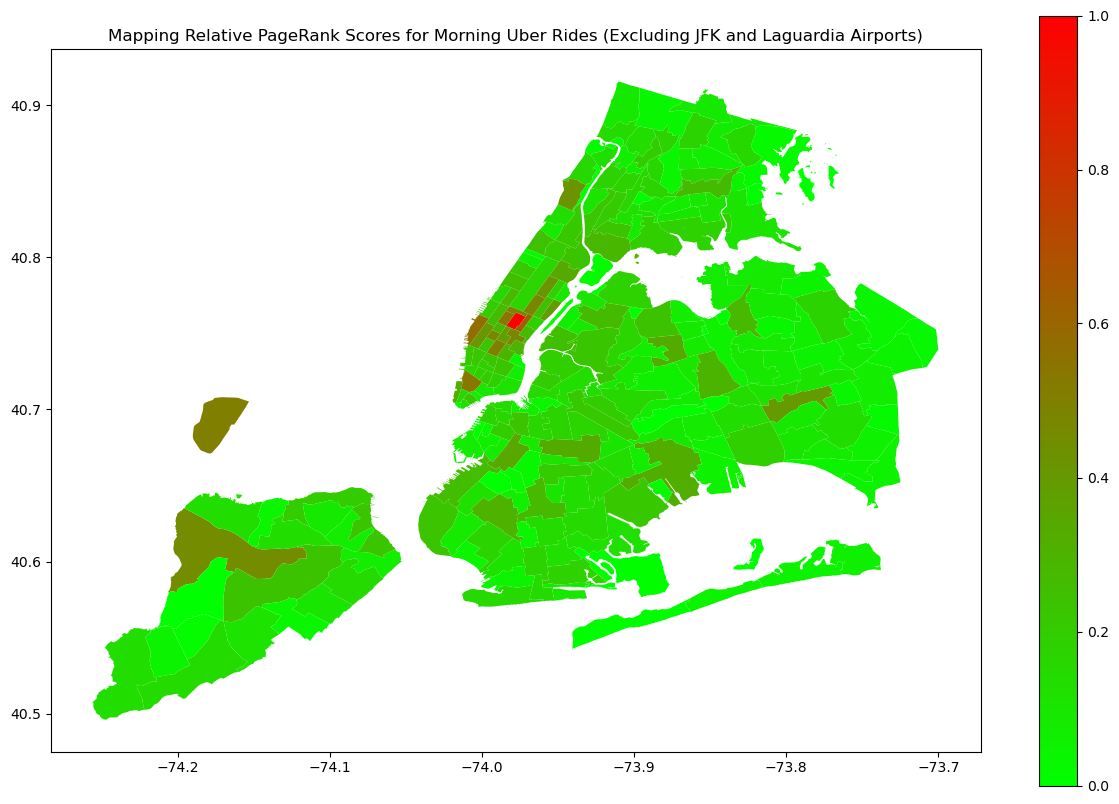

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


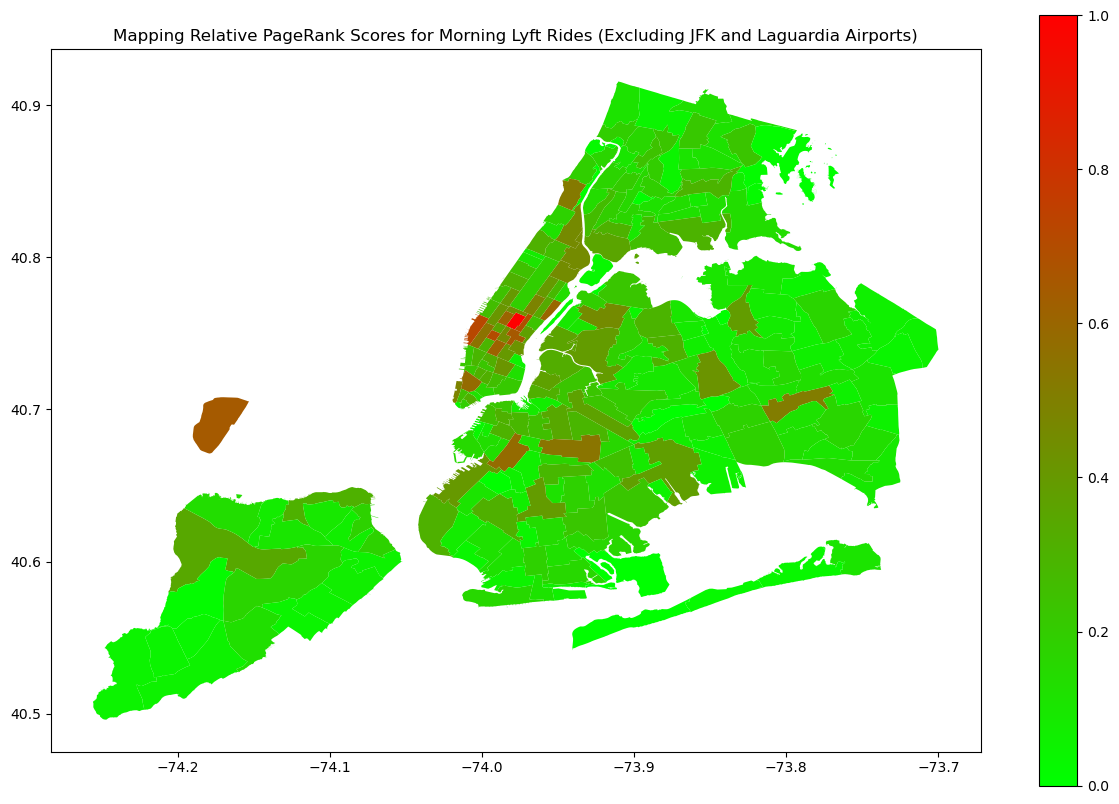

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


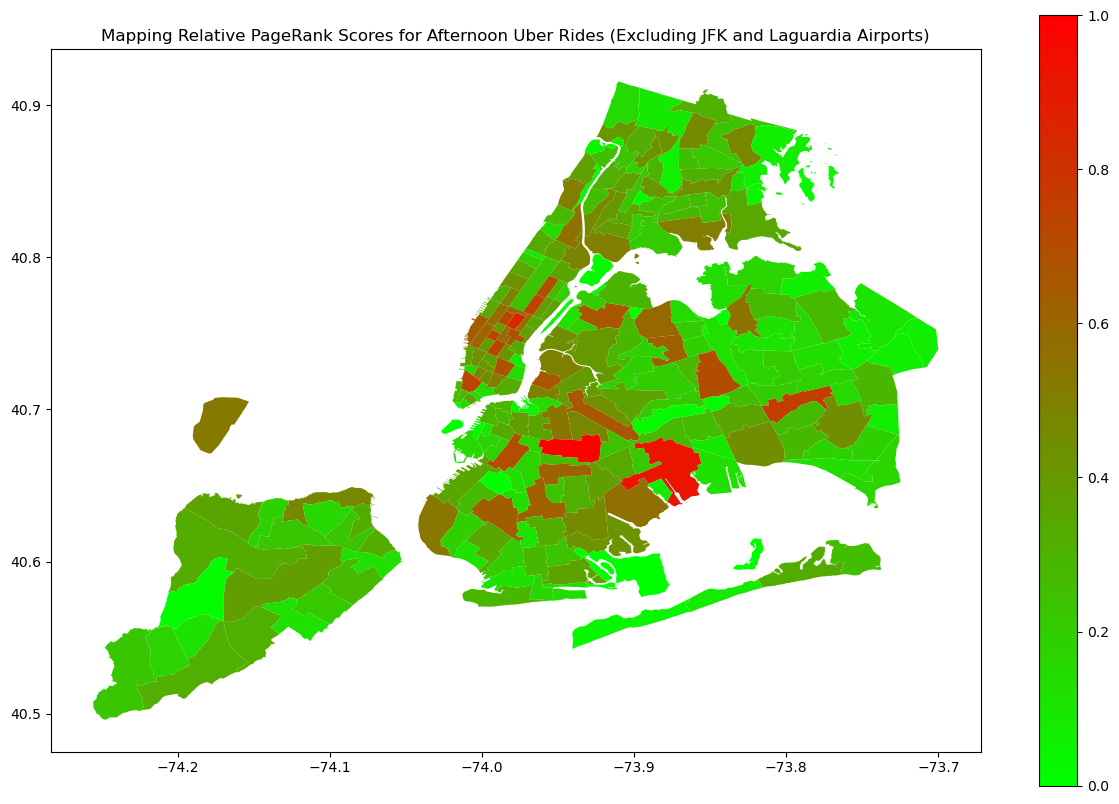

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


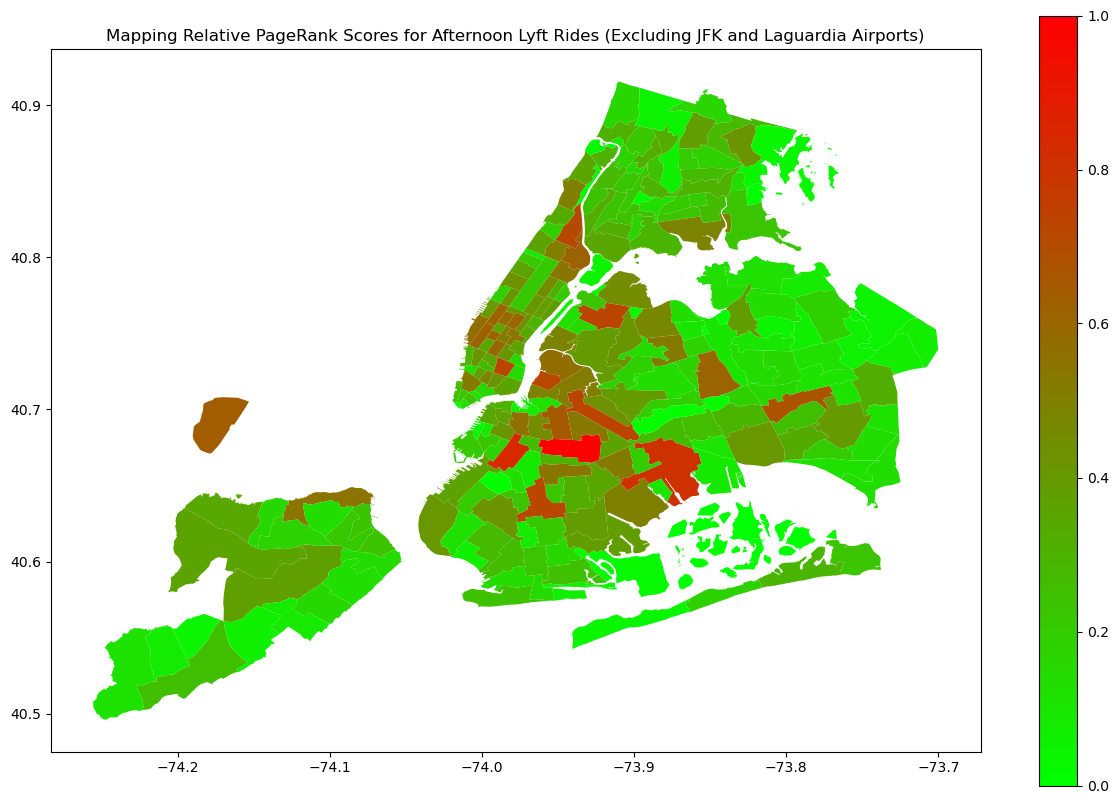

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


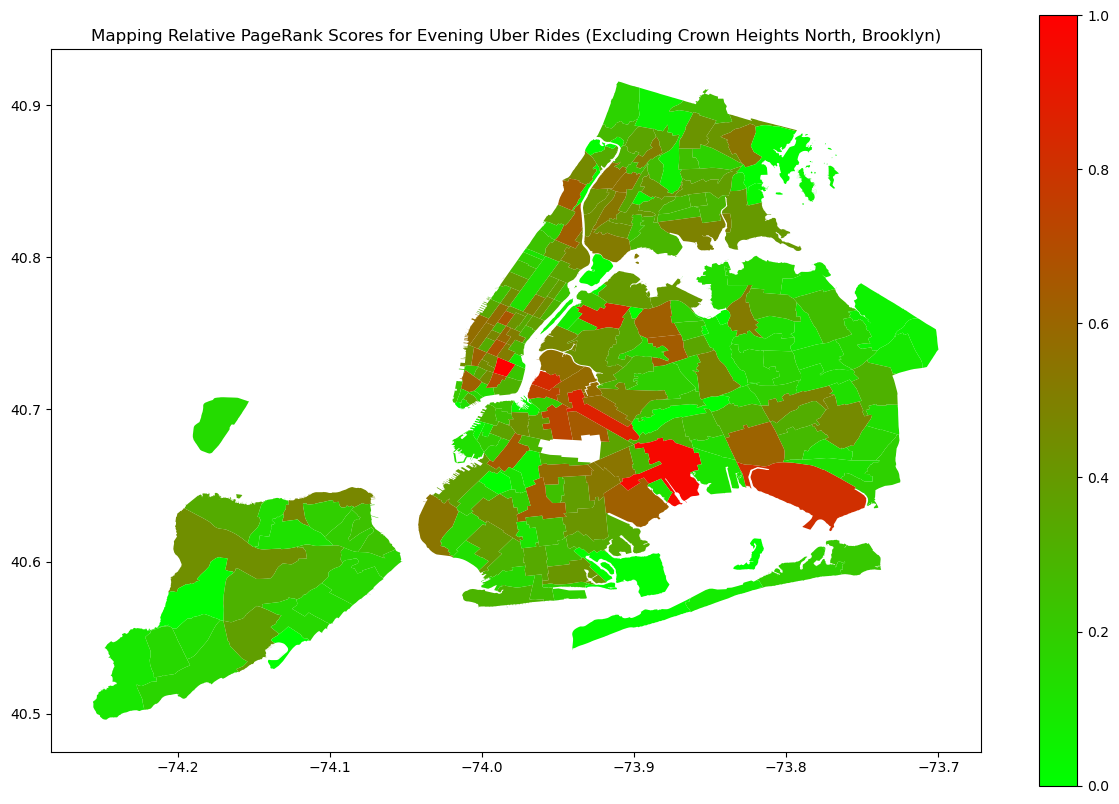

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


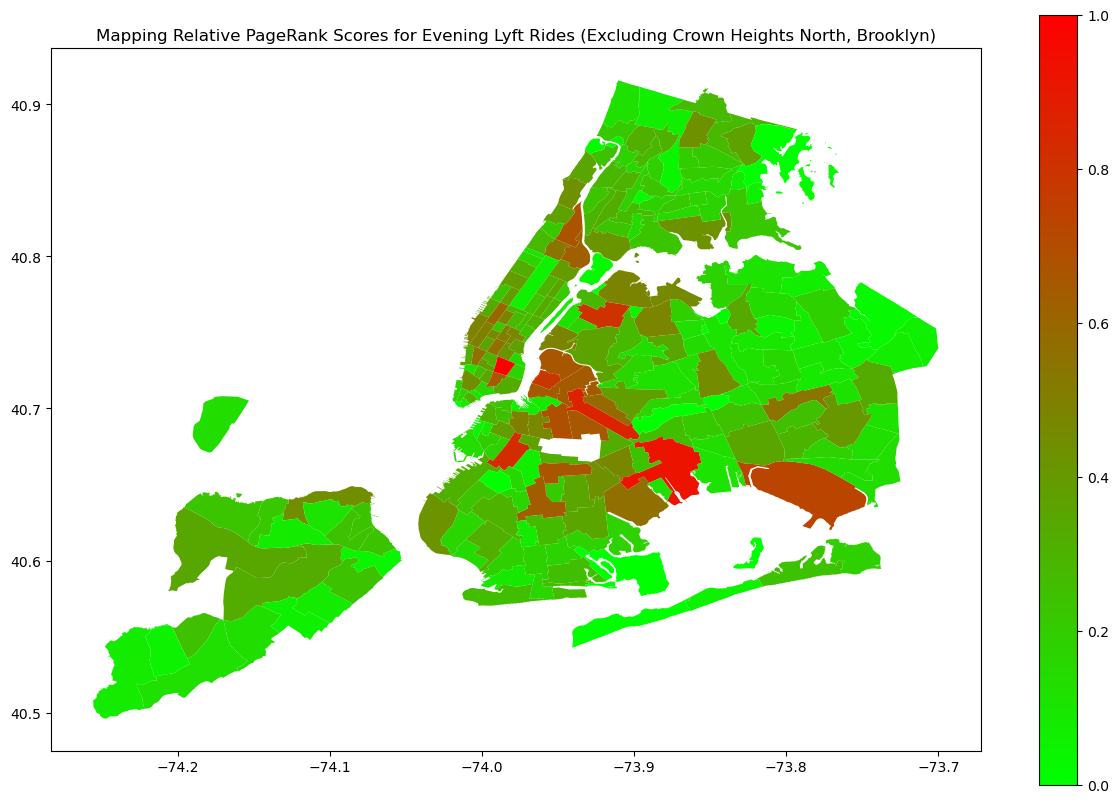

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


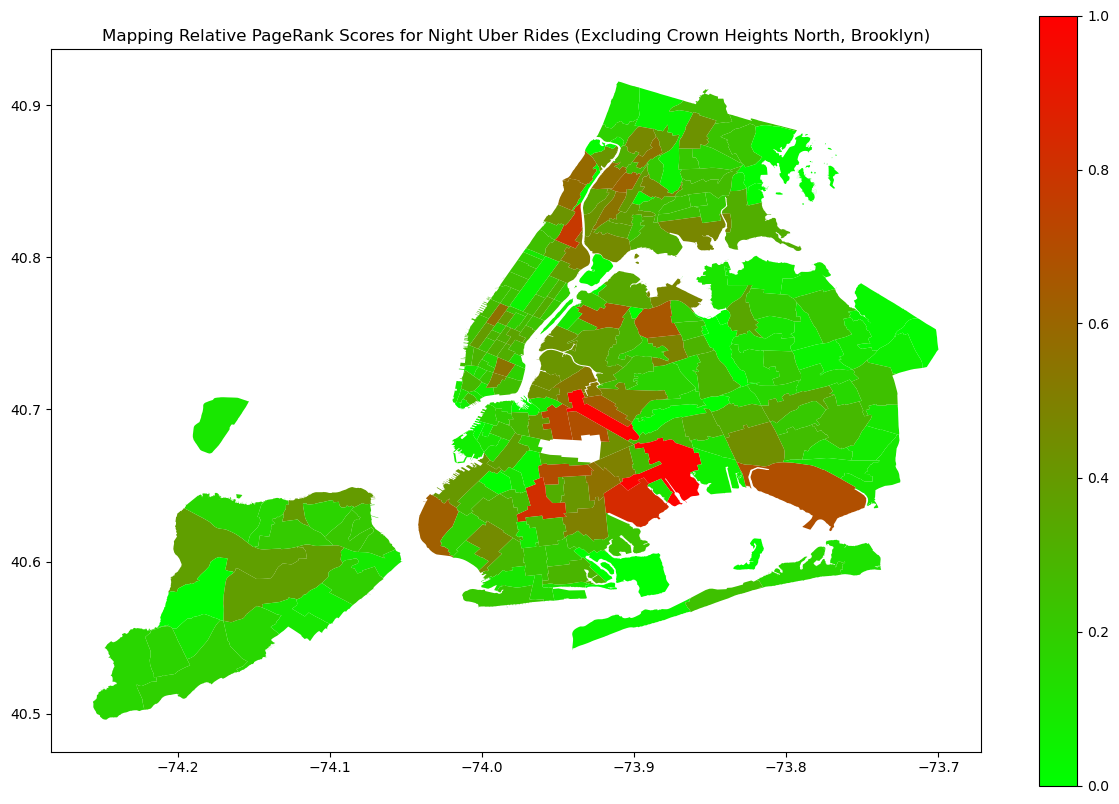

/tmp/ipykernel_25391/2245601170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])


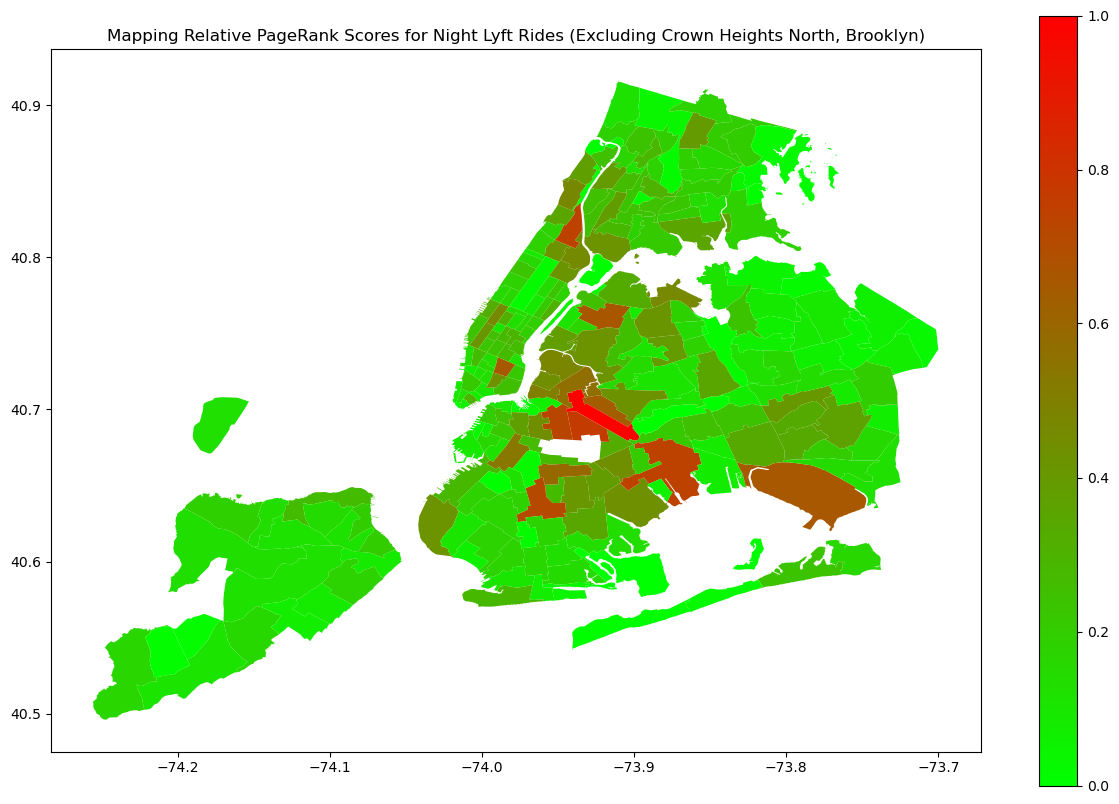

In [28]:
location_geom_df = spark.read.csv("gs://msca-bdp-student-gcs/Group_8/taxi_zones_geom_location.csv", header=True, inferSchema=True).toPandas()


# Morning Uber
morning_uber_pr_normalized, morning_uber_excluded_ids = normalize_pagerank(morning_uber_pr, exclude_top_n=2)
morning_uber_gdf = prepare_data_for_plotting(morning_uber_pr_normalized, location_geom_df, excluded_ids=morning_uber_excluded_ids)
plot_pagerank_maps(morning_uber_gdf, "Mapping Relative PageRank Scores for Morning Uber Rides (Excluding JFK and Laguardia Airports)")


#Morning Lyft
morning_lyft_pr_normalized, morning_lyft_excluded_ids = normalize_pagerank(morning_lyft_pr, exclude_top_n=2)
morning_lyft_gdf = prepare_data_for_plotting(morning_lyft_pr_normalized, location_geom_df, excluded_ids=morning_lyft_excluded_ids)
plot_pagerank_maps(morning_lyft_gdf, "Mapping Relative PageRank Scores for Morning Lyft Rides (Excluding JFK and Laguardia Airports)")


#Afternoon Uber
afternoon_uber_pr_normalized, afternoon_uber_excluded_ids = normalize_pagerank(afternoon_uber_pr, exclude_top_n=2)
afternoon_uber_gdf = prepare_data_for_plotting(afternoon_uber_pr_normalized, location_geom_df, excluded_ids=afternoon_uber_excluded_ids)
plot_pagerank_maps(afternoon_uber_gdf, "Mapping Relative PageRank Scores for Afternoon Uber Rides (Excluding JFK and Laguardia Airports)")


#Afternoon Lyft
afternoon_lyft_pr_normalized, afternoon_lyft_excluded_ids = normalize_pagerank(afternoon_lyft_pr, exclude_top_n=2)
afternoon_lyft_gdf = prepare_data_for_plotting(afternoon_lyft_pr_normalized, location_geom_df, excluded_ids=afternoon_lyft_excluded_ids)
plot_pagerank_maps(afternoon_lyft_gdf, "Mapping Relative PageRank Scores for Afternoon Lyft Rides (Excluding JFK and Laguardia Airports)")


#Evening Uber
evening_uber_pr_normalized, evening_uber_excluded_ids = normalize_pagerank(evening_uber_pr, exclude_top_n=1)
evening_uber_gdf = prepare_data_for_plotting(evening_uber_pr_normalized, location_geom_df, excluded_ids=evening_uber_excluded_ids)
plot_pagerank_maps(evening_uber_gdf, "Mapping Relative PageRank Scores for Evening Uber Rides (Excluding Crown Heights North, Brooklyn)")



#Evening Lyft
evening_lyft_pr_normalized, evening_lyft_excluded_ids = normalize_pagerank(evening_lyft_pr, exclude_top_n=1)
evening_lyft_gdf = prepare_data_for_plotting(evening_lyft_pr_normalized, location_geom_df, excluded_ids=evening_lyft_excluded_ids)
plot_pagerank_maps(evening_lyft_gdf, "Mapping Relative PageRank Scores for Evening Lyft Rides (Excluding Crown Heights North, Brooklyn)")




#Night Uber
night_uber_pr_normalized, night_uber_excluded_ids = normalize_pagerank(night_uber_pr, exclude_top_n=1)
night_uber_gdf = prepare_data_for_plotting(night_uber_pr_normalized, location_geom_df, excluded_ids=night_uber_excluded_ids)
plot_pagerank_maps(night_uber_gdf, "Mapping Relative PageRank Scores for Night Uber Rides (Excluding Crown Heights North, Brooklyn)")





#Night Lyft
night_lyft_pr_normalized, night_lyft_excluded_ids = normalize_pagerank(night_lyft_pr, exclude_top_n=1)
night_lyft_gdf = prepare_data_for_plotting(night_lyft_pr_normalized, location_geom_df, excluded_ids=night_lyft_excluded_ids)
plot_pagerank_maps(night_lyft_gdf, "Mapping Relative PageRank Scores for Night Lyft Rides (Excluding Crown Heights North, Brooklyn)")



In [54]:
from sklearn.preprocessing import MinMaxScaler

def normalize_pagerank(graph_frame):
    # Convert to Pandas DataFrame
    pandas_df = graph_frame.vertices.toPandas()

    # Normalize PageRank scores
    scaler = MinMaxScaler()
    pandas_df['pagerank_normalized'] = scaler.fit_transform(pandas_df[['pagerank']])

    return pandas_df





In [55]:
import geopandas as gpd
from shapely import wkt


def prepare_data_for_plotting(pr_df, location_geom_df):
    
    # Ensure the 'id' column in pr_df is of the same type as 'OBJECTID' in location_geom_df
    pr_df['id'] = pr_df['id'].astype(location_geom_df['OBJECTID'].dtype)
    
    # Join PageRank DataFrame with location geometry DataFrame
    merged_df = pr_df.merge(location_geom_df, left_on='id', right_on='OBJECTID')
#     uber_graph_cluster_geom = uber_graph_cluster.join(location_geom_df, uber_graph_cluster.id == location_geom_df.OBJECTID)


    # Convert 'the_geom' column to geometrical data
    merged_df['geometry'] = merged_df['the_geom'].apply(wkt.loads)
    return gpd.GeoDataFrame(merged_df, geometry='geometry')


In [58]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def plot_pagerank_maps(gdf, title):
    
    # Define a custom colormap (red to green)
    cdict = {'red':   ((0.0, 0.0, 0.0),   # Green at 0
                       (1.0, 1.0, 1.0)),  # Red at 1

             'green': ((0.0, 1.0, 1.0),   # Green at 0
                       (1.0, 0.0, 0.0)),  # Red at 1

             'blue':  ((0.0, 0.0, 0.0),   # No blue component
                       (1.0, 0.0, 0.0))}  # No blue component

    custom_cmap = LinearSegmentedColormap('RedGreen', cdict)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    gdf.plot(column='pagerank_normalized', ax=ax, legend=True, cmap=custom_cmap)
    ax.set_title(title)
    plt.show()


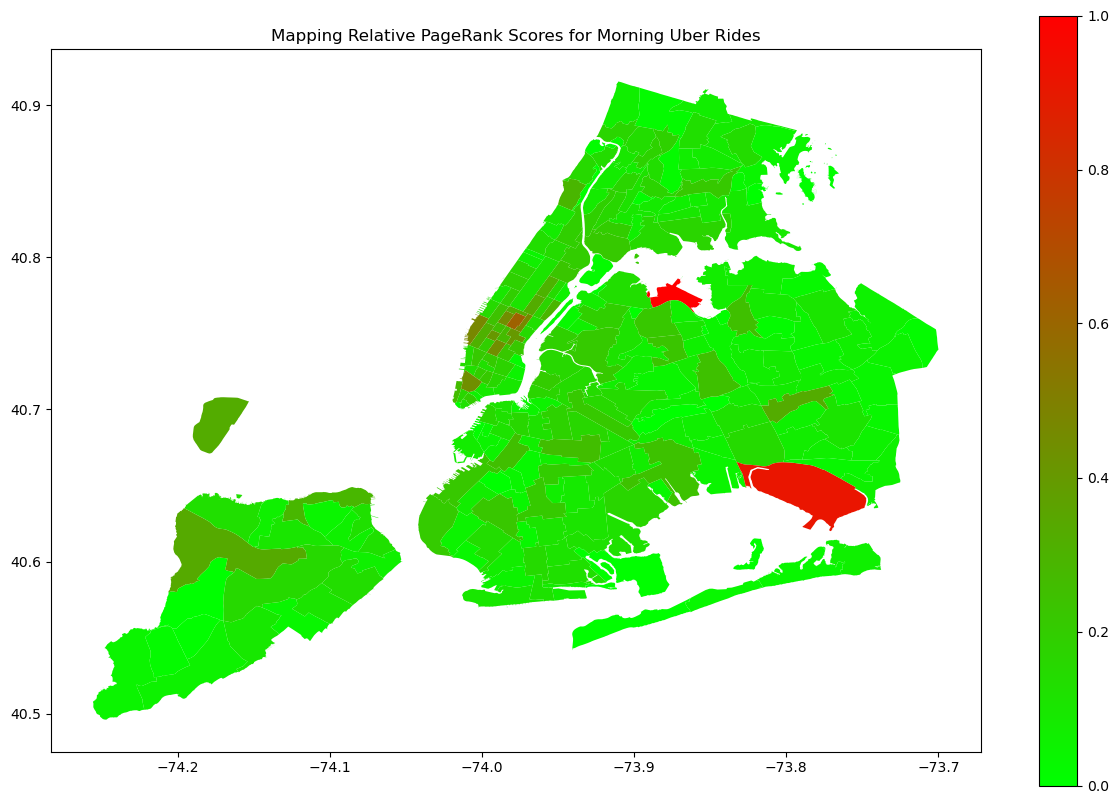

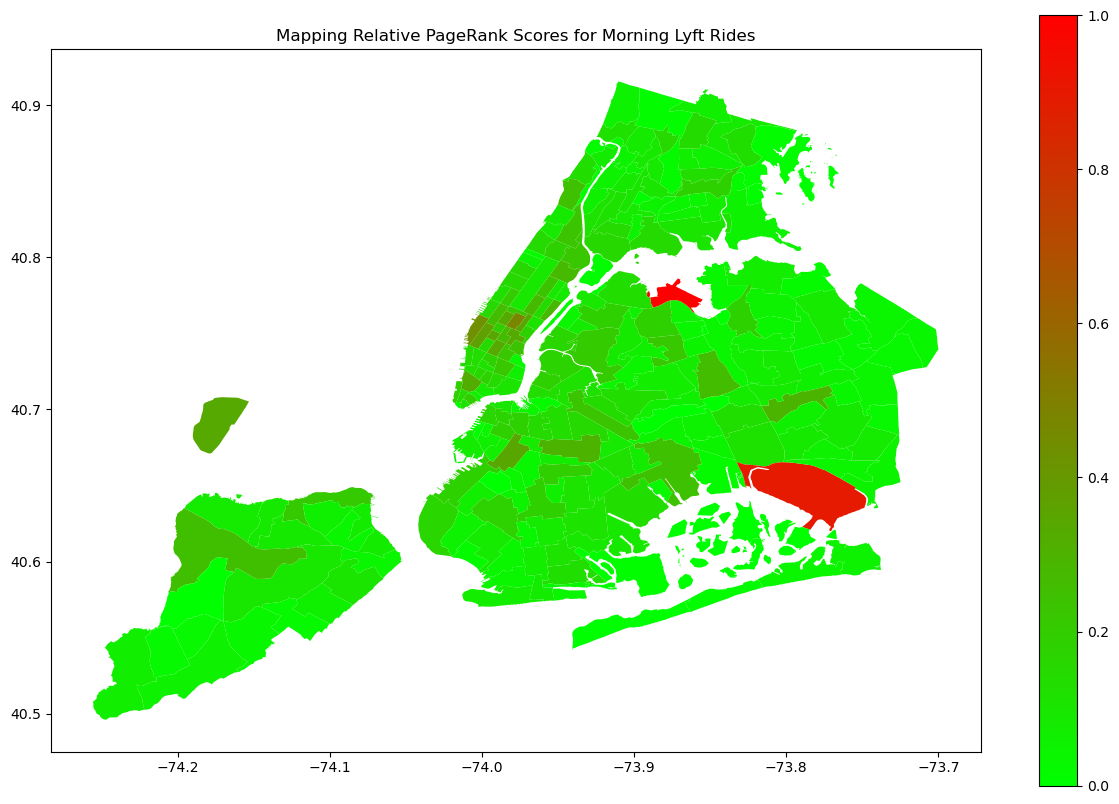

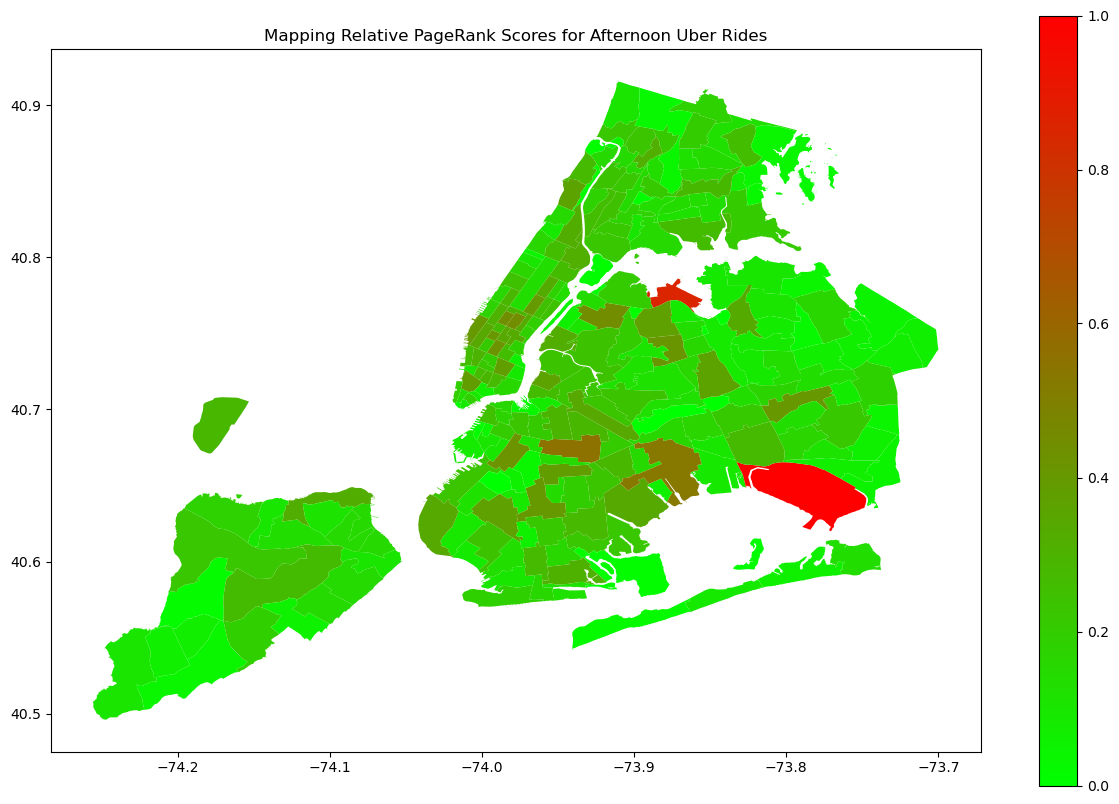

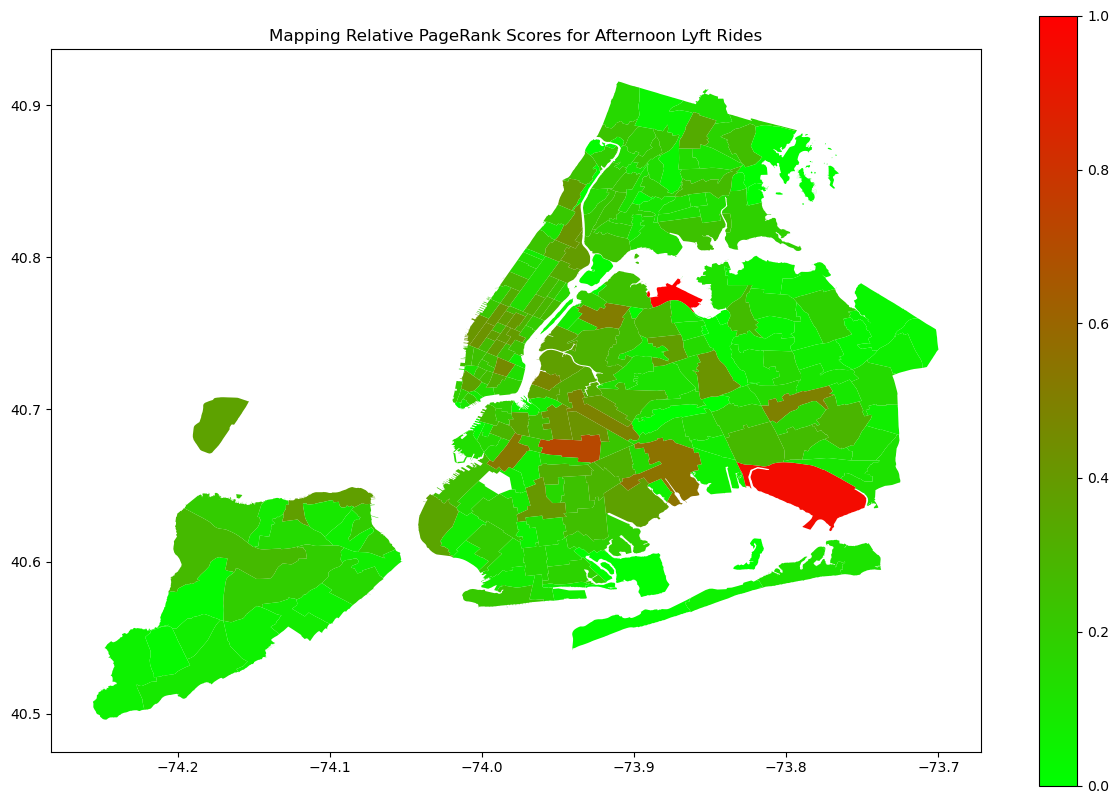

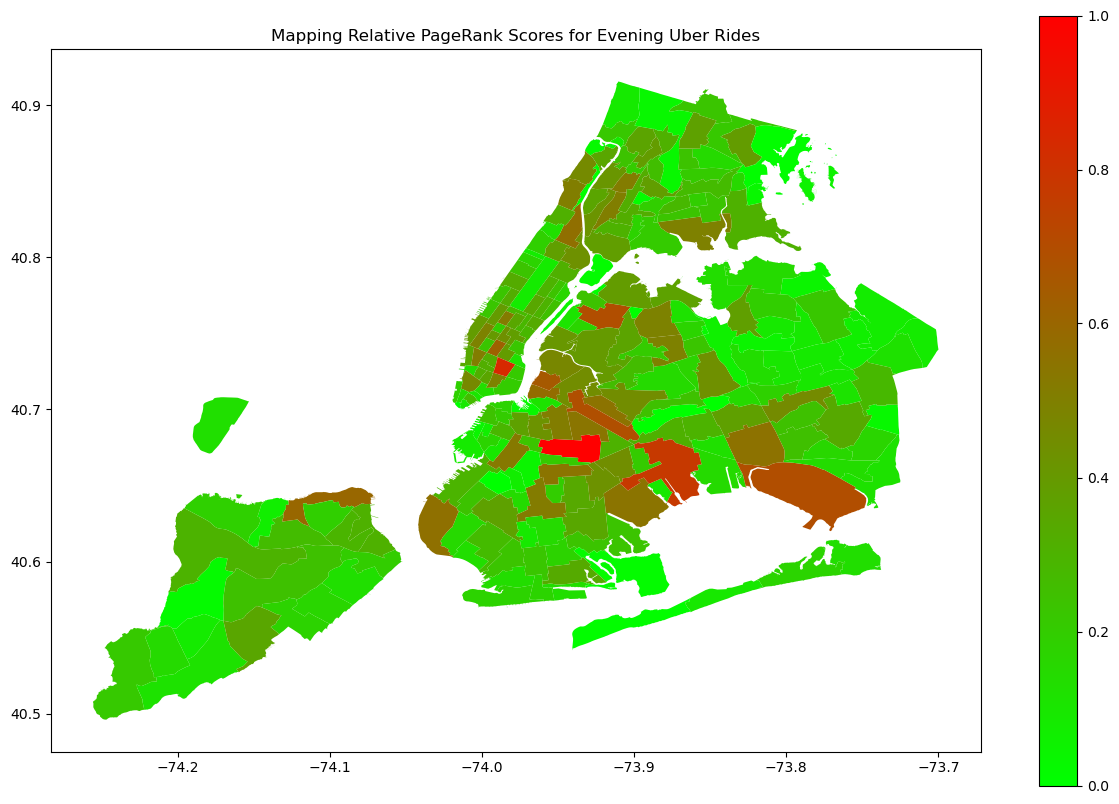

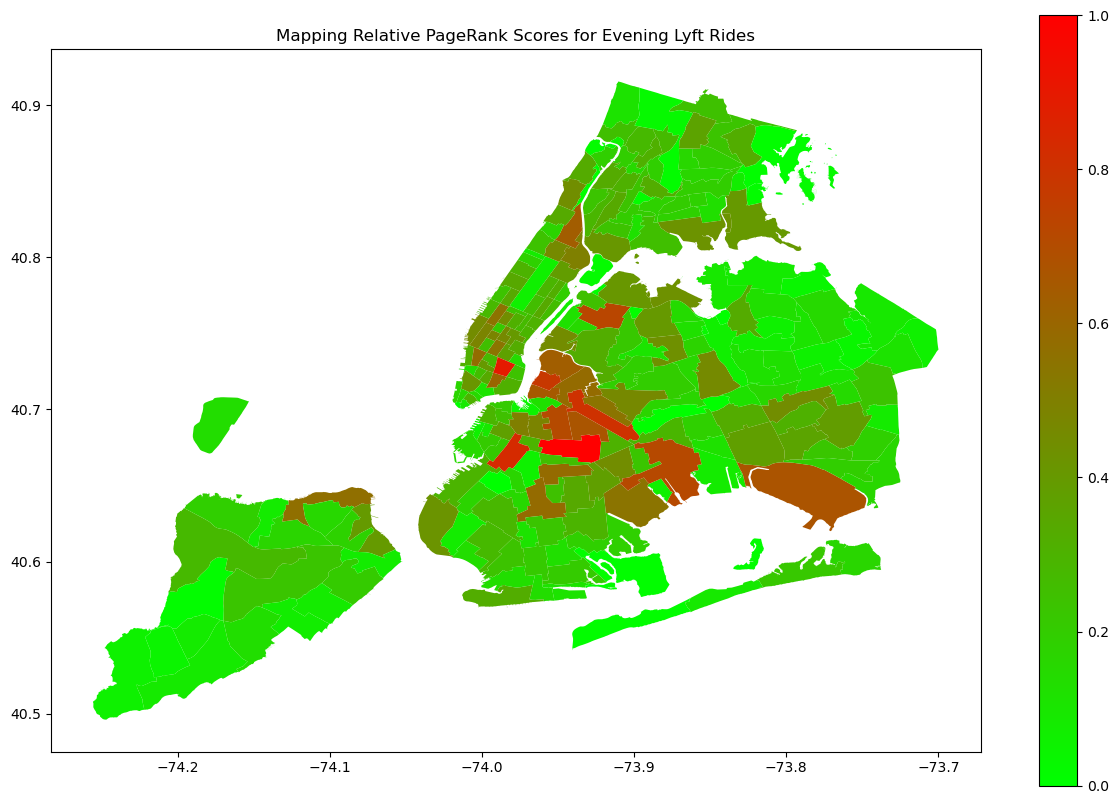

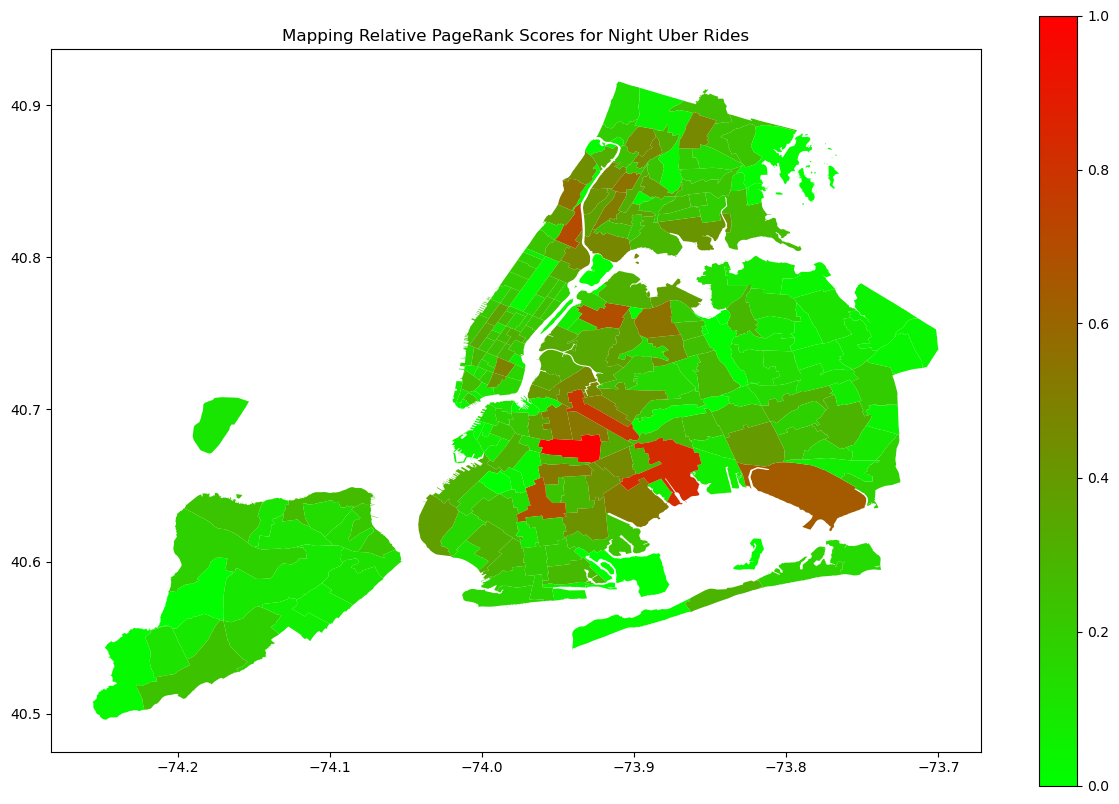

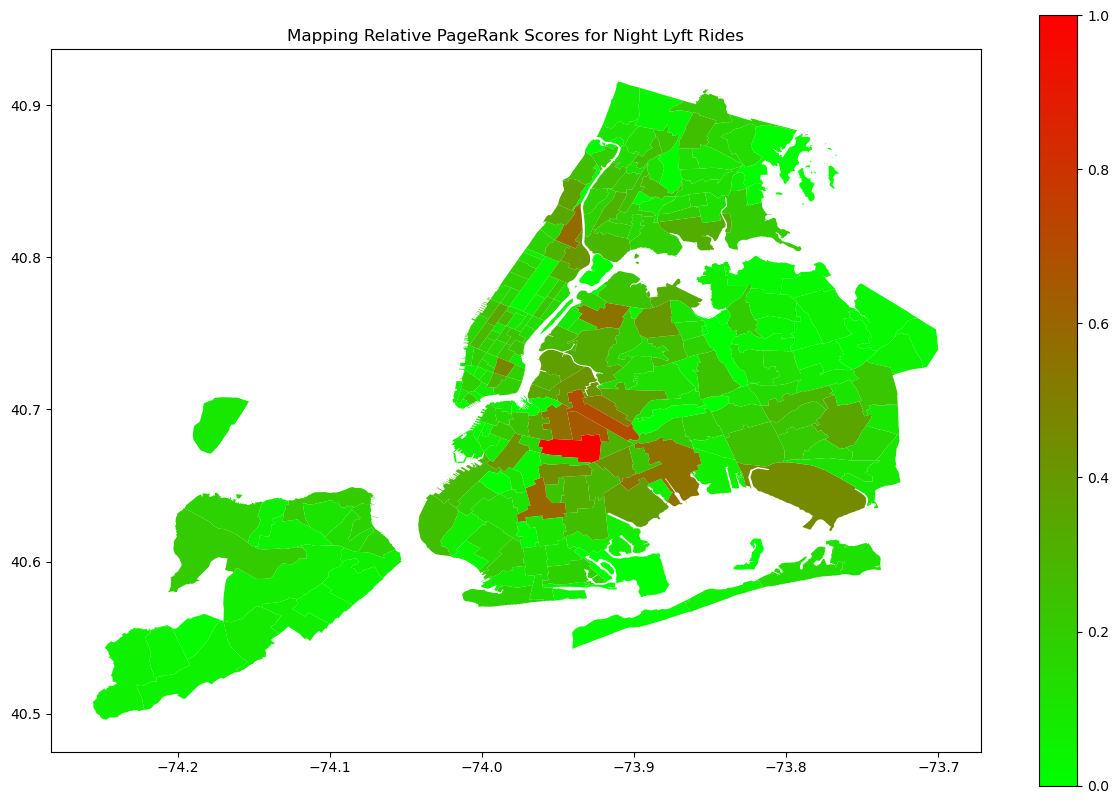

In [60]:
location_geom_df = spark.read.csv("gs://msca-bdp-student-gcs/Group_8/taxi_zones_geom_location.csv", header=True, inferSchema=True).toPandas()

morning_uber_pr_normalized = normalize_pagerank(morning_uber_pr)
morning_uber_gdf = prepare_data_for_plotting(morning_uber_pr_normalized, location_geom_df)
plot_pagerank_maps(morning_uber_gdf, "Mapping Relative PageRank Scores for Morning Uber Rides")

morning_lyft_pr_normalized = normalize_pagerank(morning_lyft_pr)
morning_lyft_gdf = prepare_data_for_plotting(morning_lyft_pr_normalized, location_geom_df)
plot_pagerank_maps(morning_lyft_gdf, "Mapping Relative PageRank Scores for Morning Lyft Rides")



afternoon_uber_pr_normalized = normalize_pagerank(afternoon_uber_pr)
afternoon_uber_gdf = prepare_data_for_plotting(afternoon_uber_pr_normalized, location_geom_df)
plot_pagerank_maps(afternoon_uber_gdf, "Mapping Relative PageRank Scores for Afternoon Uber Rides")

afternoon_lyft_pr_normalized = normalize_pagerank(afternoon_lyft_pr)
afternoon_lyft_gdf = prepare_data_for_plotting(afternoon_lyft_pr_normalized, location_geom_df)
plot_pagerank_maps(afternoon_lyft_gdf, "Mapping Relative PageRank Scores for Afternoon Lyft Rides")



evening_uber_pr_normalized = normalize_pagerank(evening_uber_pr)
evening_uber_gdf = prepare_data_for_plotting(evening_uber_pr_normalized, location_geom_df)
plot_pagerank_maps(evening_uber_gdf, "Mapping Relative PageRank Scores for Evening Uber Rides")

evening_lyft_pr_normalized = normalize_pagerank(evening_lyft_pr)
evening_lyft_gdf = prepare_data_for_plotting(evening_lyft_pr_normalized, location_geom_df)
plot_pagerank_maps(evening_lyft_gdf, "Mapping Relative PageRank Scores for Evening Lyft Rides")



night_uber_pr_normalized = normalize_pagerank(night_uber_pr)
night_uber_gdf = prepare_data_for_plotting(night_uber_pr_normalized, location_geom_df)
plot_pagerank_maps(night_uber_gdf, "Mapping Relative PageRank Scores for Night Uber Rides")

night_lyft_pr_normalized = normalize_pagerank(night_lyft_pr)
night_lyft_gdf = prepare_data_for_plotting(night_lyft_pr_normalized, location_geom_df)
plot_pagerank_maps(night_lyft_gdf, "Mapping Relative PageRank Scores for Night Lyft Rides")


In [37]:
#Label Propagation Setup

def create_graphs_for_company(company, tripdata_df):
    filtered_df = tripdata_df.filter( 
        F.col("company") == company
    )
    
    #sample_df = filtered_df.sample(fraction=0.001)-What's better??
    sample_df = filtered_df.sample(withReplacement=False, fraction=0.001)

    print(sample_df.count())

    vertices_df = (sample_df.select(F.col("PULocationID").alias("LocationID"))
                   .union(sample_df.select(F.col("DOLocationID").alias("LocationID")))
                   .distinct())

    edges_df = sample_df.select("PULocationID", "DOLocationID", 
                                  F.lit("travels to").alias("type"))

    return vertices_df, edges_df


uber_graph_vertices, uber_graph_edges = create_graphs_for_company("Uber", tripdata_df)
uber_graph_vertices = uber_graph_vertices.withColumnRenamed("LocationID", "id")
uber_graph_edges = uber_graph_edges.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
uber_graph = GraphFrame(uber_graph_vertices, uber_graph_edges)



lyft_graph_vertices, lyft_graph_edges = create_graphs_for_company("Lyft", tripdata_df)
lyft_graph_vertices = lyft_graph_vertices.withColumnRenamed("LocationID", "id")
lyft_graph_edges = lyft_graph_edges.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")
lyft_graph = GraphFrame(lyft_graph_vertices, lyft_graph_edges)



515568


183254


In [38]:
def apply_label_propagation(graph_frame):
    return graph_frame.labelPropagation(maxIter=5)

uber_graph_cluster = apply_label_propagation(uber_graph)
lyft_graph_cluster = apply_label_propagation(lyft_graph)





In [39]:
location_geom_df = spark.read.csv("gs://msca-bdp-student-gcs/Group_8/taxi_zones_geom_location.csv", header=True, inferSchema=True)


uber_graph_cluster_geom = uber_graph_cluster.join(location_geom_df, uber_graph_cluster.id == location_geom_df.OBJECTID)
lyft_graph_cluster_geom = lyft_graph_cluster.join(location_geom_df, lyft_graph_cluster.id == location_geom_df.OBJECTID)


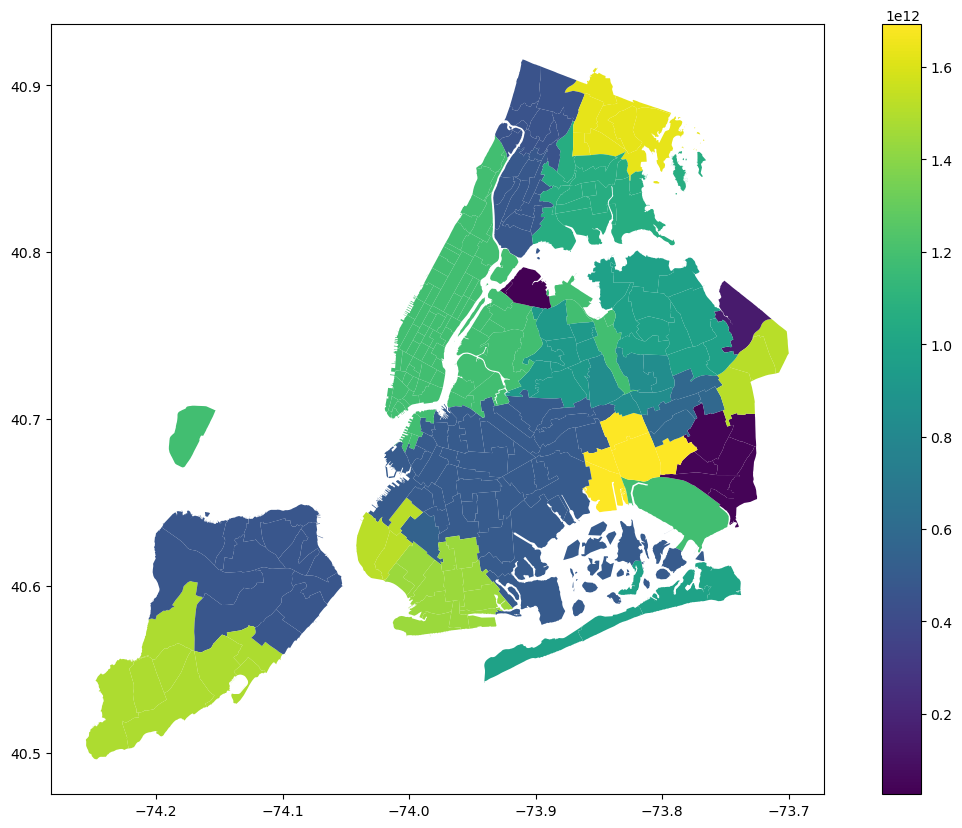

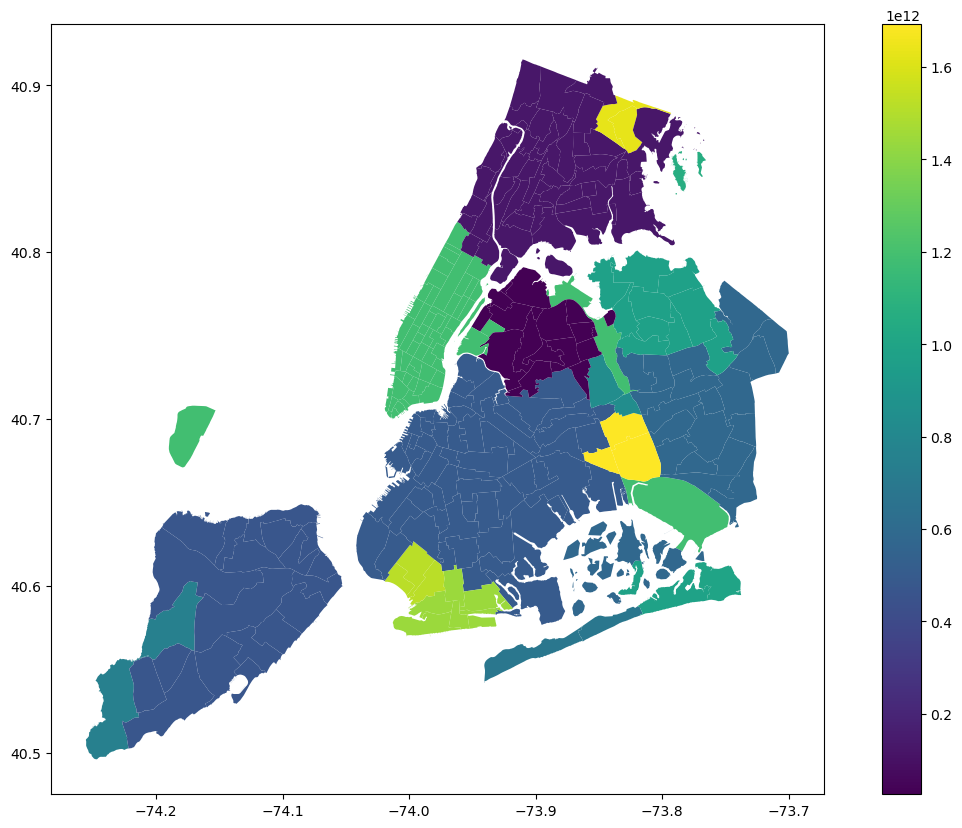

In [40]:
import geopandas as gpd
from shapely import wkt
import pandas as pd
import matplotlib.pyplot as plt




def plot_clusters(df):
    pandas_df = df.toPandas()
    pandas_df['geometry'] = pandas_df['the_geom'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(pandas_df, geometry='geometry')
    gdf.crs = 'EPSG:4326'
    gdf.plot(column='label', figsize=(15, 10), legend=True)
    plt.show()

# Apply the function to each DataFrame
plot_clusters(uber_graph_cluster_geom)
plot_clusters(lyft_graph_cluster_geom)

In [ ]:
def apply_label_propagation(graph_frame):
    return graph_frame.labelPropagation(maxIter=3)

# Apply LPA to each GraphFrame
morning_uber_clusters = apply_label_propagation(morning_uber_graph)
# afternoon_uber_clusters = apply_label_propagation(afternoon_uber_graph)
# evening_uber_clusters = apply_label_propagation(evening_uber_graph)
# night_uber_clusters = apply_label_propagation(night_uber_graph)

# morning_lyft_clusters = apply_label_propagation(morning_lyft_graph)
# afternoon_lyft_clusters = apply_label_propagation(afternoon_lyft_graph)
# evening_lyft_clusters = apply_label_propagation(evening_lyft_graph)
# night_lyft_clusters = apply_label_propagation(night_lyft_graph)


morning_uber_clusters.select("id", "label").show()
# afternoon_uber_clusters.select("id", "label").show()
# evening_uber_clusters.select("id", "label").show()
# night_uber_clusters.select("id", "label").show()

# morning_lyft_clusters.select("id", "label").show()
# afternoon_lyft_clusters.select("id", "label").show()
# evening_lyft_clusters.select("id", "label").show()
# night_lyft_clusters.select("id", "label").show()











In [19]:
location_geom_df = spark.read.csv("gs://msca-bdp-student-gcs/Group_8/taxi_zones_geom_location.csv", header=True, inferSchema=True)

morning_uber_clusters_geom = morning_uber_clusters.join(location_geom_df, morning_uber_clusters.id == location_geom_df.OBJECTID)
# afternoon_uber_clusters_geom = afternoon_uber_clusters.join(location_geom_df, afternoon_uber_clusters.id == location_geom_df.OBJECTID)
# evening_uber_clusters_geom = evening_uber_clusters.join(location_geom_df, evening_uber_clusters.id == location_geom_df.OBJECTID)
# night_uber_clusterss_geom = night_uber_clusters.join(location_geom_df, night_uber_clusters.id == location_geom_df.OBJECTID)

# morning_lyft_clusters_geom = morning_lyft_clusters.join(location_geom_df, morning_lyft_clusters.id == location_geom_df.OBJECTID)
# afternoon_lyft_clusters_geom = afternoon_lyft_clusters.join(location_geom_df, afternoon_lyft_clusters.id == location_geom_df.OBJECTID)
# evening_lyft_clusters_geom = evening_lyft_clusters.join(location_geom_df, evening_lyft_clusters.id == location_geom_df.OBJECTID)
# night_lyft_clusters_geom = night_lyft_clusters.join(location_geom_df, night_lyft_clusters.id == location_geom_df.OBJECTID)


# morning_uber_clusters_geom.show()


In [36]:
morning_uber_clusters_geom.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: long (nullable = true)
 |-- OBJECTID: integer (nullable = true)
 |-- Shape_Leng: double (nullable = true)
 |-- the_geom: string (nullable = true)
 |-- Shape_Area: double (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- borough: string (nullable = true)



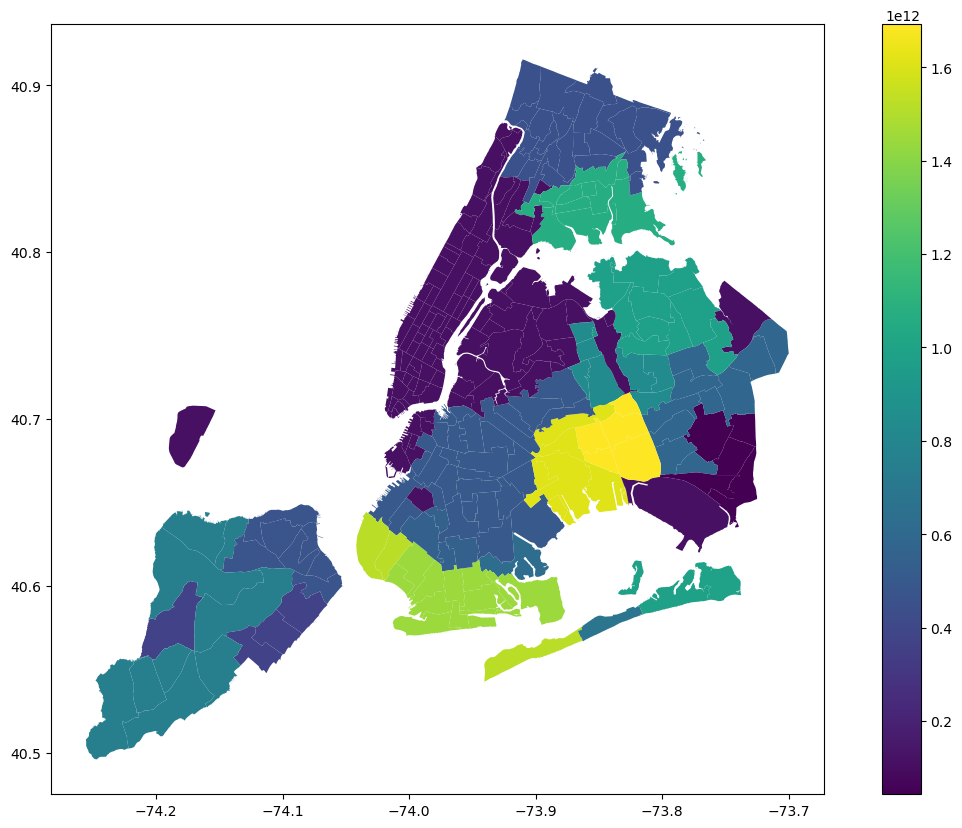

In [22]:
import geopandas as gpd
from shapely import wkt
import pandas as pd
import matplotlib.pyplot as plt




def plot_clusters(df):
    pandas_df = df.toPandas()
    pandas_df['geometry'] = pandas_df['the_geom'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(pandas_df, geometry='geometry')
    gdf.crs = 'EPSG:4326'
    gdf.plot(column='label', figsize=(15, 10), legend=True)
    plt.show()

# Apply the function to each DataFrame
plot_clusters(morning_uber_clusters_geom)
print("hello")
# plot_clusters(afternoon_uber_clusters_geom)
# plot_clusters(evening_uber_clusters_geom)
# plot_clusters(night_uber_clusters_geom)

# plot_clusters(morning_lyft_clusters_geom)
# plot_clusters(afternoon_lyft_clusters_geom)
# plot_clusters(evening_lyft_clusters_geom)
# plot_clusters(night_lyft_clusters_geom)




















# # Convert Spark DataFrame to Pandas DataFrame
# # Make sure your Spark DataFrame is small enough to fit in your driver node's memory
# pandas_df = morning_uber_clusters_geom.toPandas()

# # Convert WKT strings to geometry objects using Shapely's wkt.loads
# pandas_df['geometry'] = pandas_df['the_geom'].apply(wkt.loads)

# # Create a GeoDataFrame
# gdf = gpd.GeoDataFrame(pandas_df, geometry='geometry')

# # Set the coordinate reference system (CRS) to EPSG:4326
# gdf.crs = 'EPSG:4326'

# # Plot the data
# gdf.plot(column='label', figsize=(15, 10), legend=True)

# # Show the plot
# plt.show()




# Assuming 'morning_uber_clusters' is your DataFrame and has a 'the_geom' column with WKT strings
# First, convert the WKT strings into geometry objects



# morning_uber_clusters_geom['geometry'] = morning_uber_clusters_geom['the_geom'].apply(wkt.loads)

# # # Then, create a GeoDataFrame
# # gdf = gpd.GeoDataFrame(morning_uber_clusters, geometry='geometry')

# # # Ensure that the GeoDataFrame has the correct coordinate reference system (CRS)
# # gdf.crs = "EPSG:4326"  # Assuming the coordinates are in latitude and longitude

# # # Now, you can plot using the geometry column
# # gdf.plot(column='label', figsize=(15, 10), legend=True)

# # # Show the plot
# # plt.show()


In [22]:
def create_graphs_for_hour_and_company(hour, company, tripdata_df):
    filtered_df = tripdata_df.filter(
        (F.col("pickup_hour") == hour) &
        (F.col("company") == company)
    )
    
    # Sample the DataFrame if needed
#     sample_df = filtered_df.sample(withReplacement=False, fraction=5000 / filtered_df.count())

    #THIS IS JUST FOR TESTING!!!
    sample_df = filtered_df.sample(withReplacement=False, fraction=0.0001)

    print(sample_df.count())
    
    vertices_df = (sample_df.select(F.col("PULocationID").alias("LocationID"))
                   .union(sample_df.select(F.col("DOLocationID").alias("LocationID")))
                   .distinct())

    edges_df = sample_df.select("PULocationID", "DOLocationID", 
                                F.lit("travels to").alias("type"))

    return vertices_df, edges_df


In [ ]:
from graphframes import *

metrics_df = None

for hour in range(24):
    
    hour_uber_vertices_df, hour_uber_edges_df = create_graphs_for_hour_and_company(hour, "Uber", tripdata_df)
    hour_lyft_vertices_df, hour_lyft_edges_df = create_graphs_for_hour_and_company(hour, "Lyft", tripdata_df)

    hour_uber_vertices_df = hour_uber_vertices_df.withColumnRenamed("LocationID", "id")
    hour_uber_edges_df = hour_uber_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")

    
    hour_lyft_vertices_df = hour_lyft_vertices_df.withColumnRenamed("LocationID", "id")
    hour_lyft_edges_df = hour_lyft_edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")

    
#     hour_uber_vertices_df.show(5)
#     hour_uber_edges_df.show(5)
    
#     hour_lyft_vertices_df.show(5)
#     hour_lyft_edges_df.show(5)
    
    
    hour_uber_graph = GraphFrame(hour_uber_vertices_df, hour_uber_edges_df)
    hour_lyft_graph = GraphFrame(hour_lyft_vertices_df, hour_lyft_edges_df)
    
    
    # Calculate various metrics
    num_vertices_uber = hour_uber_graph.vertices.count()
    num_vertices_lyft = hour_lyft_graph.vertices.count()
    
    num_edges_uber = hour_uber_graph.edges.count()
    num_edges_lyft = hour_lyft_graph.edges.count()
    
    
    average_degree_uber = num_edges_uber / num_vertices_uber  # Simplified calculation
    average_degree_lyft = num_edges_lyft / num_vertices_lyft
    
    
    density_uber = num_edges_uber / (num_vertices_uber * (num_vertices_uber - 1))
    density_lyft = num_edges_lyft / (num_vertices_lyft * (num_vertices_lyft - 1))
    
    
    print(f"Uber: Hour: {hour}, Number Vertices: {num_vertices_uber}, Number Edges: {num_edges_uber}, Average Degree: {average_degree_uber}, Graph Density: {density_uber}")
    print(f"Lyft: Hour: {hour}, Number Vertices: {num_vertices_lyft}, Number Edges: {num_edges_lyft}, Average Degree: {average_degree_lyft}, Graph Density: {density_lyft}")
    # Collect the metrics in a DataFrame
    hour_metrics_uber = spark.createDataFrame([(hour, num_vertices_uber, num_edges_uber, average_degree_uber, density_uber)],
                                         ["Hour", "NumVertices", "NumEdges", "AverageDegree", "Density"])
    
    hour_metrics_lyft = spark.createDataFrame([(hour, num_vertices_lyft, num_edges_lyft, average_degree_lyft, density_lyft)],
                                         ["Hour", "NumVertices", "NumEdges", "AverageDegree", "Density"])

    metrics_df_uber = hour_metrics_uber if metrics_df is None else metrics_df.union(hour_metrics_uber)
    metrics_df_lyft = hour_metrics_lyft if metrics_df is None else metrics_df.union(hour_metrics_lyft)

# Show the results
metrics_df_uber.show()
metrics_df_lyft.show()

1897


726


Uber: Hour: 0, Number Vertices: 235, Number Edges: 1897, Average Degree: 8.072340425531914, Graph Density: 0.034497181305691946
Lyft: Hour: 0, Number Vertices: 208, Number Edges: 726, Average Degree: 3.4903846153846154, Graph Density: 0.01686176142697882


1333


506


Uber: Hour: 1, Number Vertices: 227, Number Edges: 1333, Average Degree: 5.872246696035242, Graph Density: 0.02598339246033293
Lyft: Hour: 1, Number Vertices: 204, Number Edges: 506, Average Degree: 2.480392156862745, Graph Density: 0.012218680575678547


857


370


Uber: Hour: 2, Number Vertices: 225, Number Edges: 857, Average Degree: 3.8088888888888888, Graph Density: 0.017003968253968254
Lyft: Hour: 2, Number Vertices: 183, Number Edges: 370, Average Degree: 2.021857923497268, Graph Density: 0.011109109469765208


692


290


Uber: Hour: 3, Number Vertices: 211, Number Edges: 692, Average Degree: 3.279620853080569, Graph Density: 0.015617242157526518
Lyft: Hour: 3, Number Vertices: 173, Number Edges: 290, Average Degree: 1.676300578034682, Graph Density: 0.009745933593224896


701


274


Uber: Hour: 4, Number Vertices: 218, Number Edges: 701, Average Degree: 3.2155963302752295, Graph Density: 0.014818416268549444
Lyft: Hour: 4, Number Vertices: 166, Number Edges: 274, Average Degree: 1.6506024096385543, Graph Density: 0.010003650967506389


878


326


Uber: Hour: 5, Number Vertices: 224, Number Edges: 878, Average Degree: 3.919642857142857, Graph Density: 0.017576873798846895
Lyft: Hour: 5, Number Vertices: 177, Number Edges: 326, Average Degree: 1.8418079096045197, Graph Density: 0.0104648176682075


1249


452


Uber: Hour: 6, Number Vertices: 233, Number Edges: 1249, Average Degree: 5.360515021459228, Graph Density: 0.023105668195944947
Lyft: Hour: 6, Number Vertices: 208, Number Edges: 452, Average Degree: 2.173076923076923, Graph Density: 0.010497956150130064


2059


670


Uber: Hour: 7, Number Vertices: 245, Number Edges: 2059, Average Degree: 8.404081632653062, Graph Density: 0.0344429575108732
Lyft: Hour: 7, Number Vertices: 222, Number Edges: 670, Average Degree: 3.018018018018018, Graph Density: 0.013656190126778362


2528


790


Uber: Hour: 8, Number Vertices: 244, Number Edges: 2528, Average Degree: 10.360655737704919, Graph Density: 0.04263644336504081
Lyft: Hour: 8, Number Vertices: 224, Number Edges: 790, Average Degree: 3.5267857142857144, Graph Density: 0.01581518257527226


2380


773


Uber: Hour: 9, Number Vertices: 246, Number Edges: 2380, Average Degree: 9.674796747967479, Graph Density: 0.03948896631823461
Lyft: Hour: 9, Number Vertices: 221, Number Edges: 773, Average Degree: 3.497737556561086, Graph Density: 0.015898807075277663


2127


741


Uber: Hour: 10, Number Vertices: 245, Number Edges: 2127, Average Degree: 8.681632653061225, Graph Density: 0.03558046169287387
Lyft: Hour: 10, Number Vertices: 236, Number Edges: 741, Average Degree: 3.139830508474576, Graph Density: 0.013360980887125857


2168


734


Uber: Hour: 11, Number Vertices: 246, Number Edges: 2168, Average Degree: 8.8130081300813, Graph Density: 0.03597146175543388
Lyft: Hour: 11, Number Vertices: 225, Number Edges: 734, Average Degree: 3.2622222222222224, Graph Density: 0.014563492063492063


2279


798


Uber: Hour: 12, Number Vertices: 246, Number Edges: 2279, Average Degree: 9.264227642276422, Graph Density: 0.037813174050107846
Lyft: Hour: 12, Number Vertices: 234, Number Edges: 798, Average Degree: 3.41025641025641, Graph Density: 0.014636293606250688


2427


767


Uber: Hour: 13, Number Vertices: 249, Number Edges: 2427, Average Degree: 9.74698795180723, Graph Density: 0.039302370773416244
Lyft: Hour: 13, Number Vertices: 225, Number Edges: 767, Average Degree: 3.408888888888889, Graph Density: 0.015218253968253968


2567


877


Uber: Hour: 14, Number Vertices: 251, Number Edges: 2567, Average Degree: 10.227091633466136, Graph Density: 0.040908366533864544
Lyft: Hour: 14, Number Vertices: 230, Number Edges: 877, Average Degree: 3.8130434782608695, Graph Density: 0.01665084488323524


2696


864


Uber: Hour: 15, Number Vertices: 247, Number Edges: 2696, Average Degree: 10.914979757085021, Graph Density: 0.044369836410914715
Lyft: Hour: 15, Number Vertices: 229, Number Edges: 864, Average Degree: 3.7729257641921397, Graph Density: 0.016547920018386578


2785


871


Uber: Hour: 16, Number Vertices: 248, Number Edges: 2785, Average Degree: 11.22983870967742, Graph Density: 0.045464934047277
Lyft: Hour: 16, Number Vertices: 229, Number Edges: 871, Average Degree: 3.8034934497816595, Graph Density: 0.01668198881483184


3044


1042


Uber: Hour: 17, Number Vertices: 247, Number Edges: 3044, Average Degree: 12.323886639676113, Graph Density: 0.05009710016128501
Lyft: Hour: 17, Number Vertices: 231, Number Edges: 1042, Average Degree: 4.510822510822511, Graph Density: 0.01961227178618483


3246


1051


Uber: Hour: 18, Number Vertices: 247, Number Edges: 3246, Average Degree: 13.1417004048583, Graph Density: 0.0534215463612126
Lyft: Hour: 18, Number Vertices: 230, Number Edges: 1051, Average Degree: 4.569565217391304, Graph Density: 0.019954433263717486


3040


1022


Uber: Hour: 19, Number Vertices: 246, Number Edges: 3040, Average Degree: 12.357723577235772, Graph Density: 0.05043968807035009
Lyft: Hour: 19, Number Vertices: 229, Number Edges: 1022, Average Degree: 4.462882096069869, Graph Density: 0.019574044281008198


Uber: Hour: 20, Number Vertices: 247, Number Edges: 2851, Average Degree: 11.54251012145749, Graph Density: 0.04692077285145321
Lyft: Hour: 20, Number Vertices: 228, Number Edges: 1041, Average Degree: 4.565789473684211, Graph Density: 0.020113610016230004


2726


1016


Uber: Hour: 21, Number Vertices: 246, Number Edges: 2726, Average Degree: 11.08130081300813, Graph Density: 0.04522979923676788
Lyft: Hour: 21, Number Vertices: 224, Number Edges: 1016, Average Degree: 4.535714285714286, Graph Density: 0.02033952594490711


2625


1044


Uber: Hour: 22, Number Vertices: 243, Number Edges: 2625, Average Degree: 10.802469135802468, Graph Density: 0.04463830221405979
Lyft: Hour: 22, Number Vertices: 222, Number Edges: 1044, Average Degree: 4.702702702702703, Graph Density: 0.021279197749785986


2499


926


Uber: Hour: 23, Number Vertices: 245, Number Edges: 2499, Average Degree: 10.2, Graph Density: 0.04180327868852459
Lyft: Hour: 23, Number Vertices: 218, Number Edges: 926, Average Degree: 4.247706422018348, Graph Density: 0.019574683972434788


+----+-----------+--------+-------------+-------------------+
|Hour|NumVertices|NumEdges|AverageDegree|            Density|
+----+-----------+--------+-------------+-------------------+
|  23|        245|    2499|         10.2|0.04180327868852459|
+----+-----------+--------+-------------+-------------------+

+----+-----------+--------+-----------------+--------------------+
|Hour|NumVertices|NumEdges|    AverageDegree|             Density|
+----+-----------+--------+-----------------+--------------------+
|  23|        218|     926|4.247706422018348|0.019574683972434788|
+----+-----------+--------+-----------------+--------------------+



In [ ]:
def create_weighted_graph_for_hour_and_company(hour, company, tripdata_df):
    filtered_df = tripdata_df.filter(
        (F.col("pickup_hour") == hour) &
        (F.col("company") == company)
    )

    # Example: using the number of trips as weight
    edges_df = filtered_df.groupBy("PULocationID", "DOLocationID").count().withColumnRenamed("count", "weight")

In [6]:
# Renaming columns for vertices and edges DataFrames
vertices_df = vertices_df.withColumnRenamed("LocationID", "id")
edges_df = edges_df.withColumnRenamed("PULocationID", "src").withColumnRenamed("DOLocationID", "dst")


In [7]:
from graphframes import *

g = GraphFrame(vertices_df, edges_df)

In [10]:
## Check the number of edges of each vertex
g.degrees.show()

+---+--------+
| id|  degree|
+---+--------+
|125| 4688475|
|  7|14367519|
| 51| 5306870|
|124| 1845280|
|205| 5376797|
|169| 7410051|
|234|15932615|
|232| 6804833|
| 54|  820102|
| 15|  922143|
|155| 4419711|
|132|22933376|
|154|  176492|
|200| 2477837|
| 11| 1566140|
|101|  952510|
|138|22679212|
| 69| 8072778|
| 29| 2887043|
| 42|14132369|
+---+--------+
only showing top 20 rows



In [ ]:
pr = g.pageRank(resetProbability=0.15, maxIter = 2)#tol=0.01)## look at the pagerank score for every vertex
pr.vertices.show()

## look at the weight of every edge
pr.edges.show()

23/11/15 18:35:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 17 for reason Container marked as failed: container_1700066234084_0003_01_000017 on host: hub-msca-bdp-dphub-students-mbellick-sw-2pm5.c.msca-bdp-student-ap.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/11/15 18:35:20 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 17 on hub-msca-bdp-dphub-students-mbellick-sw-2pm5.c.msca-bdp-student-ap.internal: Container marked as failed: container_1700066234084_0003_01_000017 on host: hub-msca-bdp-dphub-students-mbellick-sw-2pm5.c.msca-bdp-student-ap.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/11/15 18:35:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 18 for reason Container marked as failed: container_1700066234084_0003_01_000018 on host: hub

KeyboardInterrupt: 

In [ ]:
#results = graph.pageRank(resetProbability=0.15, maxIter= 10)


In [ ]:
def create_graphs_for_hour_and_company(hour, company, tripdata_df):
    filtered_df = tripdata_df.filter(
        (F.col("pickup_hour") == hour) &
        (F.col("company") == company)
    )
    
    # Sample the DataFrame if needed
    sample_df = filtered_df.sample(withReplacement=False, fraction=5000 / filtered_df.count())

    vertices_df = (sample_df.select(F.col("PULocationID").alias("LocationID"))
                   .union(sample_df.select(F.col("DOLocationID").alias("LocationID")))
                   .distinct())

    edges_df = sample_df.select("PULocationID", "DOLocationID", 
                                F.lit("travels to").alias("type"))

    return GraphFrame(vertices_df, edges_df)


In [ ]:
metrics_df = None

for hour in range(24):
    graph = create_graphs_for_hour_and_company(hour, "Uber", tripdata_df)
    
    # Calculate various metrics
    num_vertices = graph.vertices.count()
    num_edges = graph.edges.count()
    average_degree = num_edges / num_vertices  # Simplified calculation

    # Collect the metrics in a DataFrame
    hour_metrics = spark.createDataFrame([(hour, num_vertices, num_edges, average_degree)],
                                         ["Hour", "NumVertices", "NumEdges", "AverageDegree"])

    metrics_df = hour_metrics if metrics_df is None else metrics_df.union(hour_metrics)

# Show the results
metrics_df.show()


In [ ]:
def create_weighted_graph_for_hour_and_company(hour, company, tripdata_df):
    filtered_df = tripdata_df.filter(
        (F.col("pickup_hour") == hour) &
        (F.col("company") == company)
    )

    # Example: using the number of trips as weight
    edges_df = filtered_df.groupBy("PULocationID", "DOLocationID").count().withColumnRenamed("count", "weight")
    
    # Continue as before to create vertices and GraphFrame
    # ...
